In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import albumentations as A
from tqdm import tqdm
import copy
import ctypes

import matplotlib.pyplot as plt
import seaborn as sns


import cv2
from PIL import Image
import io
import h5py
import os, gc, time

# Deep learning library
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms # use pytorch data argument
from torchvision.models import efficientnet_b0, efficientnet_v2_m, swin_b
from torchvision import models

# Accelerate parts
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed # reproducability across devices



# Sklearn train test split/ LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


#system
import psutil

import warnings
warnings.filterwarnings("ignore")



In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
def memoryInfo():
    memory_info = psutil.virtual_memory()

    # Print the used and available memory
    print(f"Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
    print(f"Available Memory: {memory_info.available / (1024 ** 3):.2f} GB")
    print(f"Used Memory: {memory_info.used / (1024 ** 3):.2f} GB")
    print(f"Percentage Used: {memory_info.percent}%")


In [ ]:
memoryInfo()

Total Memory: 31.36 GB
Available Memory: 30.00 GB
Used Memory: 0.91 GB
Percentage Used: 4.3%


In [ ]:
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        gc.collect()
        ctypes.CDLL("libc.so.6").malloc_trim(0)
        time.sleep(0.3)

In [ ]:
clearMemory()

In [ ]:
!pip show accelerate # build-in support accelerate for multiple-GPU , later implement pytorch multiple GPU

Name: accelerate
Version: 0.32.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.10/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: catalyst


## From Timm Library find support CNN/transformer model name
#### [Timm Docs](https://timm.fast.ai/)

In [ ]:
avail_pretrained_models = timm.list_models(pretrained=False)
len(avail_pretrained_models), avail_pretrained_models[:5]

(1112,
 ['bat_resnext26ts',
  'beit_base_patch16_224',
  'beit_base_patch16_384',
  'beit_large_patch16_224',
  'beit_large_patch16_384'])

In [ ]:
avail_pretrained_models[250:400]

['efficientvit_b0',
 'efficientvit_b1',
 'efficientvit_b2',
 'efficientvit_b3',
 'efficientvit_l1',
 'efficientvit_l2',
 'efficientvit_l3',
 'efficientvit_m0',
 'efficientvit_m1',
 'efficientvit_m2',
 'efficientvit_m3',
 'efficientvit_m4',
 'efficientvit_m5',
 'ese_vovnet19b_dw',
 'ese_vovnet19b_slim',
 'ese_vovnet19b_slim_dw',
 'ese_vovnet39b',
 'ese_vovnet39b_evos',
 'ese_vovnet57b',
 'ese_vovnet99b',
 'eva02_base_patch14_224',
 'eva02_base_patch14_448',
 'eva02_base_patch16_clip_224',
 'eva02_enormous_patch14_clip_224',
 'eva02_large_patch14_224',
 'eva02_large_patch14_448',
 'eva02_large_patch14_clip_224',
 'eva02_large_patch14_clip_336',
 'eva02_small_patch14_224',
 'eva02_small_patch14_336',
 'eva02_tiny_patch14_224',
 'eva02_tiny_patch14_336',
 'eva_giant_patch14_224',
 'eva_giant_patch14_336',
 'eva_giant_patch14_560',
 'eva_giant_patch14_clip_224',
 'eva_large_patch14_196',
 'eva_large_patch14_336',
 'fastvit_ma36',
 'fastvit_mci0',
 'fastvit_mci1',
 'fastvit_mci2',
 'fastvit_

In [ ]:
timm.list_models("*efficientnet*", pretrained=True)

['efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'gc_efficientnetv2_rw_t.agc_in1k',
 'tf_efficientnet_b0.aa_in1k',
 'tf_efficientnet_b0.ap_in1k',
 'tf_efficientnet_b0.in1k',
 'tf_efficientnet_b0.ns_jft_in1k',
 'tf_efficientnet_b1.aa_in1k',
 'tf_efficientnet_b1.ap_in1k',
 'tf_efficientnet_b1.in1k',
 'tf_efficientnet_b1.ns_jft_in1k',
 'tf_efficientnet_b2.aa_in1k',
 'tf_efficientnet_b2.ap_in1k',
 'tf_efficientnet_b2.in1k',
 'tf_efficientnet_b2.ns_jft_in1k',
 'tf_e

In [ ]:
timm.list_models('*swin*', pretrained=True)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


In [ ]:
timm.list_models('*deit*', pretrained=True)

['deit3_base_patch16_224.fb_in1k',
 'deit3_base_patch16_224.fb_in22k_ft_in1k',
 'deit3_base_patch16_384.fb_in1k',
 'deit3_base_patch16_384.fb_in22k_ft_in1k',
 'deit3_huge_patch14_224.fb_in1k',
 'deit3_huge_patch14_224.fb_in22k_ft_in1k',
 'deit3_large_patch16_224.fb_in1k',
 'deit3_large_patch16_224.fb_in22k_ft_in1k',
 'deit3_large_patch16_384.fb_in1k',
 'deit3_large_patch16_384.fb_in22k_ft_in1k',
 'deit3_medium_patch16_224.fb_in1k',
 'deit3_medium_patch16_224.fb_in22k_ft_in1k',
 'deit3_small_patch16_224.fb_in1k',
 'deit3_small_patch16_224.fb_in22k_ft_in1k',
 'deit3_small_patch16_384.fb_in1k',
 'deit3_small_patch16_384.fb_in22k_ft_in1k',
 'deit_base_distilled_patch16_224.fb_in1k',
 'deit_base_distilled_patch16_384.fb_in1k',
 'deit_base_patch16_224.fb_in1k',
 'deit_base_patch16_384.fb_in1k',
 'deit_small_distilled_patch16_224.fb_in1k',
 'deit_small_patch16_224.fb_in1k',
 'deit_tiny_distilled_patch16_224.fb_in1k',
 'deit_tiny_patch16_224.fb_in1k',
 'regnety_160.deit_in1k']

# Define Configure and Path

In [ ]:
class CFG:
    seed = 42
    test_size= 0.2 # for evaluation

    # dataset
    imgSize = 300#224#300 #312 # 224  # avoid use large image size (memory size limitation)
    img_resize=True # False if pad with zeros instead of resize

    # define used CNN/transformer Model name from timm pytorch image
    modelName1 = "efficientnet_b0.ra_in1k" #  efficientnet v1 b0
    modelName2 = "tf_efficientnetv2_b1.in1k" # efficientnet v2 b1
    modelName3 = "swin_tiny_patch4_window7_224.ms_in22k" # swin transformer v1 base
    modelName4 = "swinv2_cr_tiny_ns_224.sw_in1k" # swin transformer v2 tiny
    modelName5 =  "tf_efficientnet_b1.ns_jft_in1k" #efficientnet v1 b1
    modelName6 = "tf_efficientnetv2_b2.in1k" # efficientnet v2 b2  #avoid use b2 model easy GPU out of memory
    modelName7 = "deit_base_distilled_patch16_224.fb_in1k" # deit vision transformer
    modelName8 = "deit3_base_patch16_224.fb_in1k" # deit3 vision transformer

    # train model parameter
    pretrained = False #define not use pretrained weight
    lastLayerHiddenDim = 1280
    outDim = 1

    lr = 2e-4  # r
    weightDecay = 1e-5
    trainBatchSize = 64 #32#64
    valBatchSize =  64 #32#64#128
    inferBatchSize = 64 #32#64#128
    trainEpochs = 50 #1#2#3
    numClass = 2

    USE_EFFECTNetv1 = True#False#True
    USE_EFFECTNetv2 = True
    USE_SWINTransV1 = False#True#False
    USE_SWINTransV2 = False
    USE_VITrans     = False#True # Deit vision transformer
    USE_VITrans3    = False#True  # DeiT3 vision transformer
    modelSaveDir = "/kaggle/working/"

    # pAUC core paramer
    tprTh = 0.8

    train = True # set train
    infer = True # set test

class PATHS:
    trainImagePath = "/kaggle/input/isic-2024-challenge/train-image.hdf5"
    testImagePath = "/kaggle/input/isic-2024-challenge/test-image.hdf5"
    trainMetaDataPath= "/kaggle/input/isic-2024-challenge/train-metadata.csv"
    testMetaDataPath = "/kaggle/input/isic-2024-challenge/test-metadata.csv"
    submissionPath = "/kaggle/input/isic-2024-challenge/sample_submission.csv"



In [ ]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.seed)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     accelerator = Accelerator()
#     device = accelerator.device
# else:
#     device = torch.device("cpu")

device

device(type='cuda')

In [ ]:
if torch.cuda.is_available():
    !nvidia-smi

Wed Sep  4 04:55:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load Dataset

In [ ]:
trainMetaData = pd.read_csv(PATHS.trainMetaDataPath)
testMetaData = pd.read_csv(PATHS.testMetaDataPath)
submission = pd.read_csv(PATHS.submissionPath)

In [ ]:
trainMetaData

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [ ]:
testMetaData

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [ ]:
submission

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


# EDA

In [ ]:
def printUniqueValue(df, showAll= True):
    for col in df.columns:
        if showAll ==True:
            print(f"""{col} :  {df[col].unique()}""")
        else:
            if df[col].dtype == "object": # only show object type columns unique values
                print(f"{col} : {df[col].unique()}")

In [ ]:
printUniqueValue(trainMetaData, True)

isic_id :  ['ISIC_0015670' 'ISIC_0015845' 'ISIC_0015864' ... 'ISIC_9999960'
 'ISIC_9999964' 'ISIC_9999967']
target :  [0 1]
patient_id :  ['IP_1235828' 'IP_8170065' 'IP_6724798' ... 'IP_4004571' 'IP_1487179'
 'IP_7696347']
age_approx :  [60. 65. 55. 75. 50. 70. 85. 45. 40. nan 30. 80. 35. 25. 15. 20.  5.]
sex :  ['male' 'female' nan]
anatom_site_general :  ['lower extremity' 'head/neck' 'posterior torso' 'anterior torso'
 'upper extremity' nan]
clin_size_long_diam_mm :  [ 3.04  1.1   3.4  ... 16.28 16.11 16.77]
image_type :  ['TBP tile: close-up']
tbp_tile_type :  ['3D: white' '3D: XP']
tbp_lv_A :  [20.2444223  31.71257    22.57583    ... 17.33256672 22.28857
 16.7929    ]
tbp_lv_Aext :  [16.26197518 25.36474    17.12817    ... 12.36439742  9.564721
 11.43473   ]
tbp_lv_B :  [26.92244739 26.331      37.97046    ... 29.84532611 28.4312
 21.45722   ]
tbp_lv_Bext :  [23.95477313 24.54929    33.48541    ... 26.50007324 27.01225
 21.21491   ]
tbp_lv_C :  [33.68463756 41.21903    44.17492   

In [ ]:
trainMetaData["target"].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

### Seem Class is extremely imbalance

In [ ]:
# seem the dataset a lot of null value
trainMetaData.isnull().sum()

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

In [ ]:
trainMetaData["iddx_full"].value_counts()

iddx_full
Benign                                                                                                                                                           399991
Benign::Benign melanocytic proliferations::Nevus::Nevus, Atypical, Dysplastic, or Clark                                                                             228
Benign::Benign melanocytic proliferations::Nevus                                                                                                                    141
Malignant::Malignant adnexal epithelial proliferations - Follicular::Basal cell carcinoma::Basal cell carcinoma, Nodular                                             98
Indeterminate::Indeterminate melanocytic proliferations::Atypical melanocytic neoplasm                                                                               64
Benign::Benign epidermal proliferations::Seborrheic keratosis                                                                                         

<Axes: >

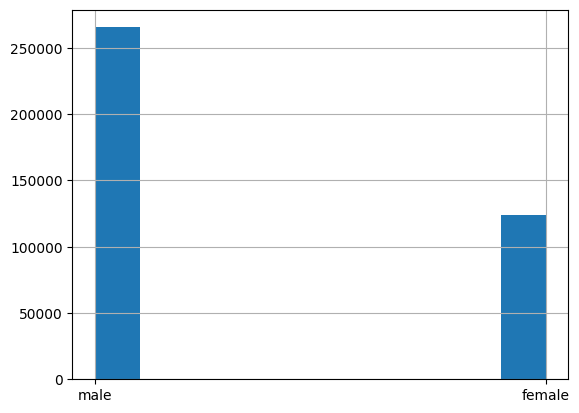

In [ ]:
trainMetaData["sex"].hist()

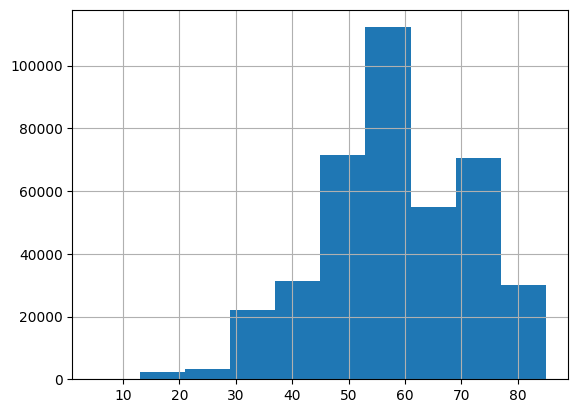

In [ ]:
trainMetaData.age_approx.hist();

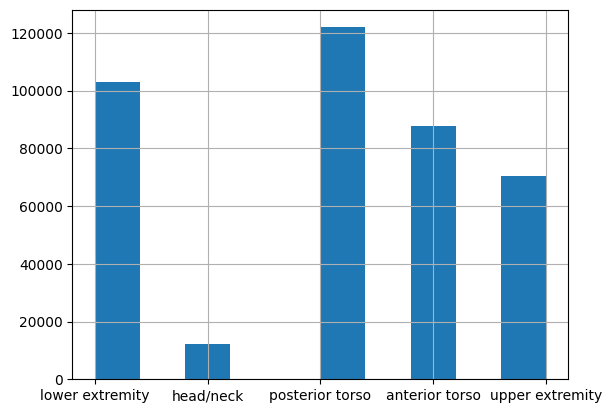

In [ ]:
trainMetaData.anatom_site_general.hist();

In [ ]:
trainMetaData.patient_id.value_counts()

patient_id
IP_1117889    9184
IP_5714646    6267
IP_3921915    5568
IP_7797815    4454
IP_9577633    3583
              ... 
IP_5792391       1
IP_1216329       1
IP_4004571       1
IP_1487179       1
IP_7696347       1
Name: count, Length: 1042, dtype: int64

### show level of confident of train dataset

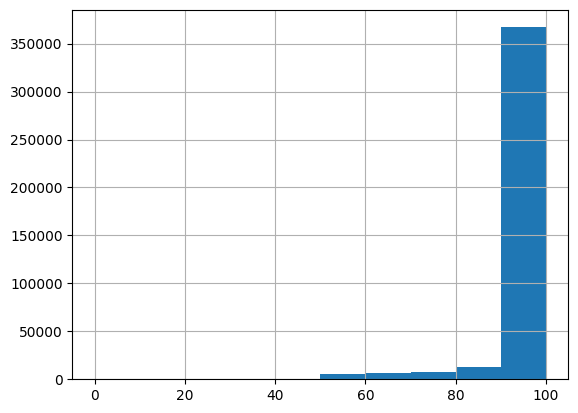

In [ ]:
trainMetaData.tbp_lv_dnn_lesion_confidence.hist();

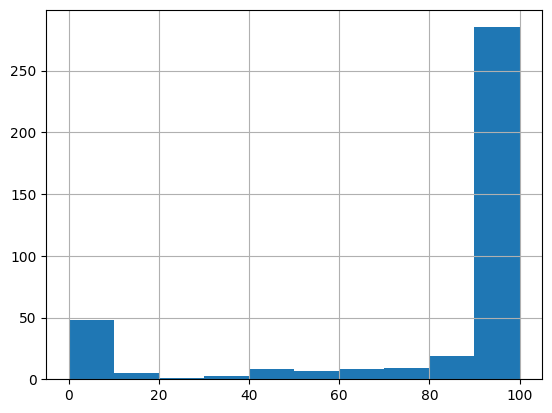

In [ ]:
# find target == 1 confident level distribution
trainMetaData[trainMetaData["target"] == 1].tbp_lv_dnn_lesion_confidence.hist();

## Extract Image dataset (train/test)

In [ ]:
def readImghdf5(filePath, transform=False):
    """
    avoid use this function, image arary data alway load in memory ,easy has out of memory issue
    """
    with h5py.File(filePath, 'r') as f:
        idsList = list(f.keys())
        print("Number of image files: ", len(idsList))
        idsImg = {}
        for i, imgId in enumerate(tqdm(idsList)):
            imgRaw = f[imgId][()]
            img = Image.open(io.BytesIO(imgRaw))
            idsImg[imgId] = np.array(img, dtype=np.uint8) #store in idsImg

            # Clear the image variable to save memory
            del img
            del imgRaw
            if i % 1000 == 999:
                gc.collect()
        if transform: #gnerate transform image
            pass

#     gc.collect()
    return idsImg

In [ ]:
clearMemory()

In [ ]:
memoryInfo()

Total Memory: 31.36 GB
Available Memory: 29.68 GB
Used Memory: 1.23 GB
Percentage Used: 5.4%


In [ ]:
%%time
# load data
# imageTrain = readImghdf5(PATHS.trainImagePath) # convert all image store in memory ( too large memory consume)
# imageTest = readImghdf5(PATHS.testImagePath)  # convert all image store in memory (too large memory consume)
trainHDF5 = h5py.File(PATHS.trainImagePath, 'r')
testHDF5 = h5py.File(PATHS.testImagePath, 'r')

CPU times: user 2.11 ms, sys: 1.21 ms, total: 3.32 ms
Wall time: 12.9 ms


#### Check image size distribution

In [ ]:
clearMemory()

# data Clearning

In [ ]:
trainMetaData["lesion_id"].notnull().sum() # check how many valid data

22058

In [ ]:
trainMetaData["lesion_id"].isnull().sum() # check how many Null invalid data

379001

In [ ]:
trainMetaData["lesion_id"]

0                NaN
1         IL_6727506
2                NaN
3                NaN
4                NaN
             ...    
401054    IL_9520694
401055           NaN
401056    IL_9852274
401057           NaN
401058           NaN
Name: lesion_id, Length: 401059, dtype: object

In [ ]:
# only filter the valid lesion id dataset
trainMetaData = trainMetaData[trainMetaData["lesion_id"].notnull()]
trainMetaData

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
49,ISIC_0073301,0,IP_2536274,40.0,female,posterior torso,9.59,TBP tile: close-up,3D: XP,24.237019,...,IL_3854228,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.886191
76,ISIC_0073989,0,IP_1307115,50.0,male,upper extremity,6.39,TBP tile: close-up,3D: white,19.600317,...,IL_9898853,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.997449
93,ISIC_0074611,0,IP_6164902,40.0,female,lower extremity,3.31,TBP tile: close-up,3D: XP,18.007100,...,IL_2988728,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
107,ISIC_0075969,0,IP_5117525,40.0,female,posterior torso,9.05,TBP tile: close-up,3D: XP,21.315824,...,IL_6219432,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400997,ISIC_9998638,0,IP_2097401,40.0,male,lower extremity,3.90,TBP tile: close-up,3D: XP,16.600171,...,IL_0041380,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
401019,ISIC_9999171,0,IP_7502403,50.0,female,anterior torso,5.51,TBP tile: close-up,3D: white,12.549400,...,IL_3334800,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,69.111250
401028,ISIC_9999315,0,IP_5337939,50.0,female,lower extremity,6.46,TBP tile: close-up,3D: XP,17.290400,...,IL_9124999,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999880
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988


In [ ]:
trainMetaData["lesion_id"].isnull().sum() #check null

0

# Seem train dataset extremely imbalance

In [ ]:
trainMetaData["target"].value_counts()

target
0    21665
1      393
Name: count, dtype: int64

In [ ]:
393/ (21665+393) * 100 # cancer image around 1.78% data

1.781666515549914

In [ ]:
trainMetaDataHasCancer= trainMetaData[trainMetaData["target"] == 1]
trainMetaDataHasCancer.shape

(393, 55)

In [ ]:
trainMetaDataNoCancer= trainMetaData[trainMetaData["target"] == 0]
trainMetaDataNoCancer

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
49,ISIC_0073301,0,IP_2536274,40.0,female,posterior torso,9.59,TBP tile: close-up,3D: XP,24.237019,...,IL_3854228,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.886191
76,ISIC_0073989,0,IP_1307115,50.0,male,upper extremity,6.39,TBP tile: close-up,3D: white,19.600317,...,IL_9898853,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.997449
93,ISIC_0074611,0,IP_6164902,40.0,female,lower extremity,3.31,TBP tile: close-up,3D: XP,18.007100,...,IL_2988728,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
107,ISIC_0075969,0,IP_5117525,40.0,female,posterior torso,9.05,TBP tile: close-up,3D: XP,21.315824,...,IL_6219432,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400997,ISIC_9998638,0,IP_2097401,40.0,male,lower extremity,3.90,TBP tile: close-up,3D: XP,16.600171,...,IL_0041380,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
401019,ISIC_9999171,0,IP_7502403,50.0,female,anterior torso,5.51,TBP tile: close-up,3D: white,12.549400,...,IL_3334800,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,69.111250
401028,ISIC_9999315,0,IP_5337939,50.0,female,lower extremity,6.46,TBP tile: close-up,3D: XP,17.290400,...,IL_9124999,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999880
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988


In [ ]:
# trainMetaDataHasCancer.info()

### Because 393 true cancar train sample data size is not enough to effective train Deep learning model, need generate more than 5 to 20 times true data by data Augmentation technique

In [ ]:
# repeat row data n Time
numGenImage =15 #6#12#10#5
newTrainMetaDataHasCancer = pd.DataFrame(np.repeat(trainMetaDataHasCancer.values, numGenImage, axis=0),
                                            columns=trainMetaDataHasCancer.columns)
# newTrainMetaDataHasCancer = trainMetaDataHasCancer
newTrainMetaDataHasCancer.shape

(5895, 55)

In [ ]:
newTrainMetaDataHasCancer["isic_id"].value_counts()

isic_id
ISIC_9996602    15
ISIC_0082829    15
ISIC_0096034    15
ISIC_0104229    15
ISIC_0119495    15
                ..
ISIC_0293670    15
ISIC_0321944    15
ISIC_0330452    15
ISIC_0332355    15
ISIC_0338720    15
Name: count, Length: 393, dtype: int64

In [ ]:
newTrainMetaDataHasCancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5895 entries, 0 to 5894
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   isic_id                       5895 non-null   object
 1   target                        5895 non-null   object
 2   patient_id                    5895 non-null   object
 3   age_approx                    5850 non-null   object
 4   sex                           5745 non-null   object
 5   anatom_site_general           5895 non-null   object
 6   clin_size_long_diam_mm        5895 non-null   object
 7   image_type                    5895 non-null   object
 8   tbp_tile_type                 5895 non-null   object
 9   tbp_lv_A                      5895 non-null   object
 10  tbp_lv_Aext                   5895 non-null   object
 11  tbp_lv_B                      5895 non-null   object
 12  tbp_lv_Bext                   5895 non-null   object
 13  tbp_lv_C          

In [ ]:
# convert target dtype in int64
newTrainMetaDataHasCancer["target"] = newTrainMetaDataHasCancer["target"].astype(np.int64)

In [ ]:
newTrainMetaDataHasCancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5895 entries, 0 to 5894
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   isic_id                       5895 non-null   object
 1   target                        5895 non-null   int64 
 2   patient_id                    5895 non-null   object
 3   age_approx                    5850 non-null   object
 4   sex                           5745 non-null   object
 5   anatom_site_general           5895 non-null   object
 6   clin_size_long_diam_mm        5895 non-null   object
 7   image_type                    5895 non-null   object
 8   tbp_tile_type                 5895 non-null   object
 9   tbp_lv_A                      5895 non-null   object
 10  tbp_lv_Aext                   5895 non-null   object
 11  tbp_lv_B                      5895 non-null   object
 12  tbp_lv_Bext                   5895 non-null   object
 13  tbp_lv_C          

In [ ]:
len(newTrainMetaDataHasCancer)

5895

In [ ]:
# downsample for no cancer training data
# trainMetaDataNoCancer = trainMetaDataNoCancer.sample(n=len(trainMetaDataHasCancer), random_state=42)
trainMetaDataNoCancer = trainMetaDataNoCancer.sample(n=len(newTrainMetaDataHasCancer), random_state=42)
trainMetaDataNoCancer.shape

(5895, 55)

In [ ]:
# balancetrainMetaData = pd.concat([trainMetaDataHasCancer, trainMetaDataNoCancer], axis=0) # combine two dataset in row axis
balancetrainMetaData = pd.concat([newTrainMetaDataHasCancer, trainMetaDataNoCancer], axis=0) # combine two dataset in row axis
balancetrainMetaData.shape

(11790, 55)

In [ ]:
# random sample order of balanced train dataset
balancetrainMetaData = balancetrainMetaData.sample(frac=1).reset_index(drop=True)
balancetrainMetaData

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_5039397,1,IP_9034566,65.0,male,upper extremity,12.98,TBP tile: close-up,3D: XP,11.08785,...,IL_4597137,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Superficial spreading",NaN,>4/mm^2,1.7,83.14064
1,ISIC_7621879,0,IP_6207479,50.0,NaN,upper extremity,2.7,TBP tile: close-up,3D: XP,19.01264,...,IL_4126365,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.99996
2,ISIC_6184108,1,IP_8877928,65.0,female,lower extremity,11.85,TBP tile: close-up,3D: white,14.12289,...,IL_7074915,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Superficial spreading",NaN,<1/mm^2,0.6,98.12862
3,ISIC_9060519,1,IP_6774617,70.0,male,anterior torso,3.18,TBP tile: close-up,3D: XP,26.24879,...,IL_7464223,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,88.16375
4,ISIC_2127595,0,IP_8316597,55.0,male,anterior torso,2.7,TBP tile: close-up,3D: XP,15.94237,...,IL_3819576,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.99869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11785,ISIC_7932948,0,IP_2263019,35.0,female,posterior torso,6.4,TBP tile: close-up,3D: XP,24.419827,...,IL_4478463,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11786,ISIC_8491708,1,IP_3343426,80.0,female,upper extremity,1.23,TBP tile: close-up,3D: XP,17.393872,...,IL_9097741,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,52.919561
11787,ISIC_8852993,1,IP_9743101,50.0,male,posterior torso,11.72,TBP tile: close-up,3D: white,21.42151,...,IL_1655369,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,NaN,NaN,NaN,NaN,99.968
11788,ISIC_1211710,1,IP_8078890,80.0,male,lower extremity,4.47,TBP tile: close-up,3D: white,11.65677,...,IL_7309714,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive","Squamous cell carcinoma, Invasive, Keratoacant...",NaN,NaN,NaN,0.001074


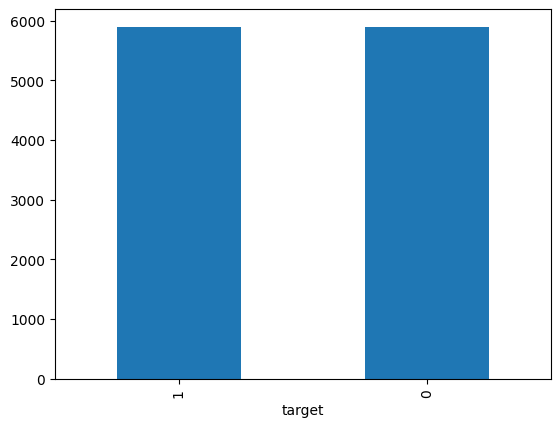

In [ ]:
balancetrainMetaData.target.value_counts().plot(kind="bar");

In [ ]:
del trainMetaData

## Create Custom DataSet

In [ ]:
class SKINCancerDatset(Dataset):
    def __init__(self,
                 metaData: pd.DataFrame,  # metadata
                 idsImg: dict, # image
                 resize : bool=True,
                 train : bool=True):
        self.metaData = metaData
        self.idsImg = idsImg
        self.resize = resize
        self.train = train # indicate it is a training dataset, with labels

    def __len__(self):
        return len(self.metaData)

    def padImg(self, img):
        padX = CFG.imgSize - img.shape[1] # calulate pad X size
        padY = CFG.imgSize - img.shape[0] # calulate pad Y size
        paddedImg =  np.pad(img,
                            ((padY//2, padY//2 + padY%2),
                             (padX//2, padX//2 + padX%2),
                             (0, 0)),
                            mode='constant', constant_values=0)
        return paddedImg

    def __getitem__(self, item):
        row= self.metaData.iloc[item] # get row
        isicId = row.isic_id
        img = self.idsImg[isicId]  # normalize
        if self.resize:
            img = cv2.resize(img, dsize=(CFG.imgSize, CFG.imgSize))
        else: # use padding image
            img = self.padImg(img)
        if self.train: # is training dataset
            label = row.target
            return img, label
        else: # test dataset (no target)
            return img

In [ ]:
class SKINCancerDatsetV2(Dataset):
    def __init__(self,
                 metaData ,  # metadata
                 hdf5File , # image file
                 transform , # transform function
                 train : bool=True):
        self.metaData = metaData
        self.hdf5File = hdf5File
        self.transform = transform
        self.train = train # indicate it is a training dataset, with labels

    def __len__(self):
        return len(self.metaData)


    def __getitem__(self, item):
        row= self.metaData.iloc[item] # get row
        isicId = row.isic_id
        img =  Image.open(io.BytesIO(self.hdf5File[isicId][()])) # convert byte array to PIL image#self.idsImg[isicId]  # normalize
        if self.transform:
            img = self.transform(img)#cv2.resize(img, dsize=(CFG.imgSize, CFG.imgSize))

        if self.train: # is training dataset
            label = row.target
            return img, label
        else: # test dataset (no target)
            return img

## Define transform function

In [ ]:
valtransformFuct = transforms.Compose([
        transforms.Resize((CFG.imgSize, CFG.imgSize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize
        ])

traintransformFuct = transforms.Compose([
        transforms.Resize((CFG.imgSize, CFG.imgSize)),
        transforms.RandomRotation(degrees=(0, 270)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
#         transforms.RandomResizedCrop(size=(CFG.imgSize, CFG.imgSize),
#                                      scale=(0.2, 0.8),
#                                      ratio=(0.05, 0.8)),
#         transforms.ColorJitter(brightness=(0.8,1.2),
#                                contrast=(1)),
#                                saturation=(0.6,1.5)),
#                                hue=(-0.5, 0.5)),
#         transforms.RandomAffine(degrees=(0, 180),
#                                 translate=(0.1, 0.2),
#                                 scale=(0.5, 1.1)),
#         transforms.RandomGrayscale(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=3.0, p=0.5),
        transforms.RandomInvert(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize
        ])

# Split Train/test dataset

In [ ]:
if CFG.train:
#     train, val = train_test_split(trainMetaData,
#                                   stratify= trainMetaData.target,
#                                   test_size= CFG.test_size,
#                                   random_state= CFG.seed)
    train, val = train_test_split(balancetrainMetaData,
                                  stratify= balancetrainMetaData.target,
                                  test_size= CFG.test_size,
                                  random_state= CFG.seed)
    print(train.target.value_counts(), val.target.value_counts())

target
0    4716
1    4716
Name: count, dtype: int64 target
0    1179
1    1179
Name: count, dtype: int64


## create train/valid dataset

In [ ]:
if CFG.train:
#     trainDataset = SKINCancerDatset(train, imageTrain,  resize=CFG.img_resize, train=True)
#     valDataset = SKINCancerDatset(val, imageTrain, resize=CFG.img_resize, train=True)
    trainDataset = SKINCancerDatsetV2(train, trainHDF5, traintransformFuct, train=True)
    valDataset = SKINCancerDatsetV2(val, trainHDF5, traintransformFuct, train=True)
    # create train/valid data loader
    trainDataLoader =torch.utils.data.DataLoader(
        trainDataset,
        batch_size=CFG.trainBatchSize,
        num_workers=4,
        shuffle=True,
        pin_memory=True,
    )
    valDataLoader =torch.utils.data.DataLoader(
        valDataset,
        batch_size=CFG.valBatchSize,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
    )

# test/submit dataset/dataloader
# testDataset = SKINCancerDatset(testMetaData, imageTest,  resize=CFG.img_resize, train=False)
testDataset = SKINCancerDatsetV2(testMetaData, testHDF5, valtransformFuct, train=False)
testDataLoader = torch.utils.data.DataLoader(
    testDataset,
    batch_size=CFG.inferBatchSize,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
)

In [ ]:
len(testDataset)

3

In [ ]:
len(trainDataLoader)

148

In [ ]:
train["isic_id"].iloc[0]

'ISIC_0934752'

Shape of X : torch.Size([64, 3, 300, 300])
Shape of y: torch.Size([64]) torch.int64
torch.Size([3, 300, 300])


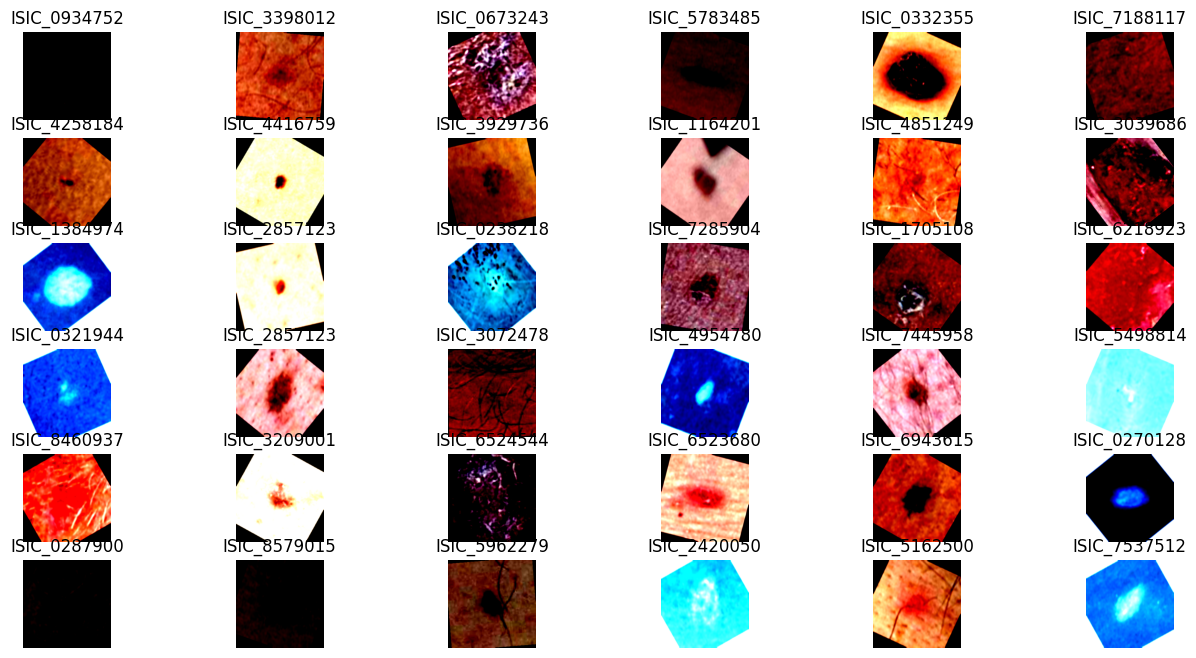

In [ ]:
#check Train Dataloader for each batch
for x, y in trainDataLoader:
    print(f"Shape of X : {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(x[0].shape)
    plt.figure(figsize=(16, 8))
#     for i in range(16):
    for i in range(36):
        plt.subplot(6, 6, i+1)
        plt.imshow(x[i].permute(1, 2, 0))
        plt.title(train["isic_id"].iloc[i])  # This assumes you have direct access to IDs in this scope
        plt.axis('off')
    plt.show()
    break


Shape of X : torch.Size([64, 3, 300, 300])
Shape of y: torch.Size([64]) torch.int64
torch.Size([3, 300, 300])


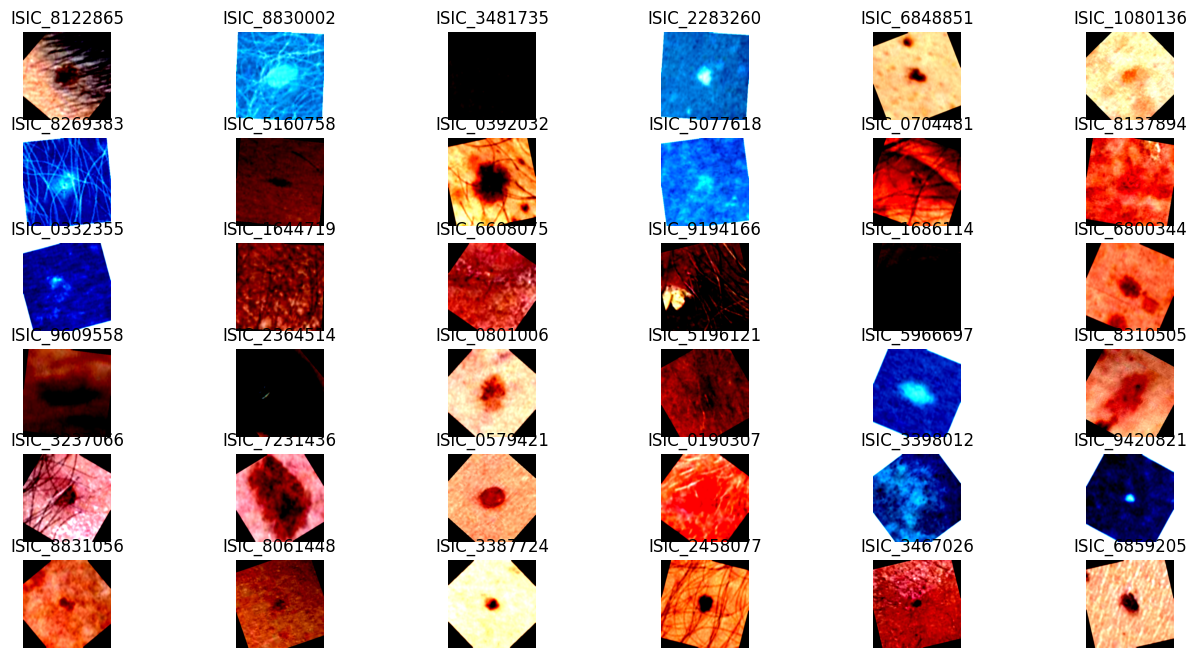

In [ ]:
for x, y in valDataLoader:
    print(f"Shape of X : {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(x[0].shape)
    plt.figure(figsize=(16, 8))
    for i in range(36):
        plt.subplot(6, 6, i+1)
        plt.imshow(x[i].permute(1, 2, 0))
        plt.title(val["isic_id"].iloc[i])  # This assumes you have direct access to IDs in this scope
        plt.axis('off')
    plt.show()
    break

Shape of X : torch.Size([3, 3, 300, 300])


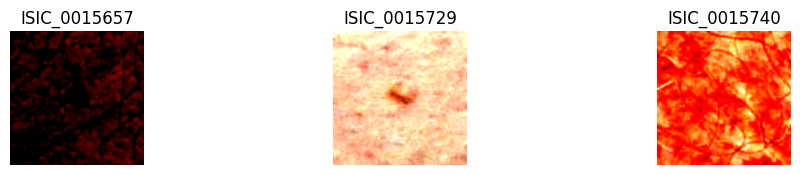

In [ ]:
for x in testDataLoader:
    print(f"Shape of X : {x.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
    plt.figure(figsize=(16, 8))
    for i in range(3):
        plt.subplot(4, 4, i+1)
        plt.imshow(x[i].permute(1, 2, 0))
        plt.title(testMetaData["isic_id"].iloc[i])  # This assumes you have direct access to IDs in this scope
        plt.axis('off')
    plt.show()
    break

In [ ]:
# plt.imshow(testDataset[0]);

# Reduce memory usage

In [ ]:
# delete unused reduce memory
# del imageTrain
# del imageTest
# del trainMetaData
# del train
# #del val

In [ ]:
# trainMetaData

In [ ]:
clearMemory()

# Create training / validation function for Pytorch

In [ ]:
def trainFunc(model, loader, optimizer, lossFn):
    """ one epoch training"""
    model.train() # set the model to training mode calculate gradients and update weights
#     size = len(loader) # total data size
    if device.type == "cuda":
        scaler = torch.cuda.amp.GradScaler(enabled=True)
#     else:
#         scaler = torch.cpu.amp.GradScaler(enabled=True)
    losses = []
    correct =0
    total= 0
    for i, data  in enumerate(tqdm(loader)):
#     for i, data in enumerate(loader, 0):
        inputs , labels = data # get into
        inputs  = inputs.to(device).float()
        labels = labels.to(device).view(-1, 1).float() # to GPU if available
#         inputs  = inputs.float()
#         labels = labels.view(-1, 1).float()# to GPU if available


        yhat = model(inputs)# prediction
#         print(inputs.shape)
#         print("yhat shape: ", yhat.shape)
        loss = lossFn(yhat, labels) # calculate loss
        losses.append(loss.item()) # record loss value

        #predict
#         predicted = yhat.sigmoid().detach().cpu().numpy() # convert to numpy
        predicted = torch.round(yhat.data) # convert into 0 or 1 (binary classifier)
#         print("predicted: ", predicted)
#         print("Labels: ", labels)
        total += labels.size(0)
#         correct += torch.sum(yhat == labels.data)#(predicted == labels).sum().item()
        correct += (predicted == labels).sum()

#         print("correct: ",correct)
        # reset previous gradient
        optimizer.zero_grad()
        if device.type == "cuda":
#             accelerator.backward(loss)
            scaler.scale(loss).backward() #getting gradients
            scaler.step(optimizer) # update weight
#             optimizer.step()
            scaler.update()
        else:
            loss.backward() # calculate new gradient
            optimizer.step() # update weight/parameter

        if i % 100 == 99: #each 100 mini-batches print the loss
            tempLoss = np.mean(losses)
            print(f"Batch {i+1},  Training Loss : {tempLoss}")
#             print("Total Correct: ", correct)
            tempAcc = 100 * correct.detach().cpu().numpy()/ (total)
            print(f"Batch {i+1}, Training Acc : {tempAcc} %")




    avgLoss = np.mean(losses)  #average losses
    accTrain  = 100 * correct.detach().cpu().numpy() /total
    print(f"Training Avg Loss: {avgLoss}")
    print(f"Training Accuracy: {accTrain}")
    return avgLoss , accTrain




In [ ]:
def validationFunc(model, loader, lossFn):
    model.eval() # set model to evaluation mode, no calcuate gradients
    losses = []
    preds = []
    correct =0
    total= 0
    with torch.no_grad():
        for i, data  in enumerate(tqdm(loader)):
#         for i , data in enumerate(loader, 0):
            inputs , labels = data # get x and y
            inputs = inputs.to(device).float()
            labels = labels.to(device).view(-1, 1).float() # to GPU if available

            #prediction
            yhat = model(inputs)
            loss = lossFn(yhat, labels)
            predicted = torch.round(yhat.data) # convert into 0 or 1 (binary classifier)
            preds.append(predicted.detach().cpu().numpy()) # prediction
            losses.append(loss.item())

            #predict
#             predicted = yhat.sigmoid().detach().cpu().numpy()
            total += labels.size(0)
#             correct += torch.sum(yhat == labels.data)# (predicted == labels).sum().item()
            correct +=   (predicted == labels).sum()

            if i % 100 == 99: #each 100 mini-batches print the loss
                tempLoss = np.mean(losses)
                print(f"Batch {i+1},  Val Loss : {tempLoss}")
                tempAcc =  100 * correct.detach().cpu().numpy()/ (total)
                print(f"Batch {i+1}, Val Acc : {tempAcc} %")

    preds = np.concatenate(preds, 0)
    avgLoss = np.mean(losses) #
    accVal  = 100 * (correct.detach().cpu().numpy()) /total
    print(f"Val Avg Loss: {avgLoss}")
    print(f"Val Accuracy: {accVal} %")
    return avgLoss, accVal , preds


# inference for submission

In [ ]:

def inferFunc(model, loader):
    model.eval() # set model to evaluation mode, no calcuate gradients
    preds = []
    with torch.no_grad():
        for i , data in enumerate(loader, 0):
            inputs = data.to(device).float()

            #preiction
            yhat = model(inputs)
            preds.append(yhat.sigmoid().detach().cpu().numpy())
    preds = np.concatenate(preds, 0)
    return preds

# Partial AUC socre function for metrics

In [ ]:
def plotPartialAUC(fpr, tpr, auc):
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for  Classification')
    plt.legend()
    plt.show()

In [ ]:
def computePAUC(ytrue, ypred, tprThreshold=0.8):
    """
    computer Partial AUC score with TPR Threshold
    """
    # computer ROC curve
    fpr, tpr, thresholds = roc_curve(ytrue, ypred)

    # Find the indices where the TPR is above the threshold
    tprAboveThr = np.where(tpr>= tprThreshold)[0]

    if len(tprAboveThr) ==0:
        return 0.0 #  all below tpr threshold

    #Extract index for ROC segment about threshold
    start = tprAboveThr[0]
    fprAboveThr = fpr[start:]
    tprAboveThr = tpr[start:] - tprThreshold

    partialAUC = auc(fprAboveThr, tprAboveThr)
#     plotPartialAUC(fprAboveThr, tprAboveThr, partialAUC)

    return partialAUC




In [ ]:
def computePAUCV2(targets, predictions, tprThreshold=0.80):
    # Ensure the inputs are numpy arrays for processing
    targets = np.array(targets)
    predictions = np.array(predictions)

    v_gt = abs(targets - 1)  # Assuming 'targets' are 0s and 1s
    v_pred = 1.0 - predictions  # Inverting predictions if necessary

    max_fpr = abs(1 - tprThreshold)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)

    # Adjust scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

# Test Computing pAUC

In [ ]:

y_true = np.array([0, 1, 0])
y_preds = np.array([0.1, 0.4, 0.35])

pauc = computePAUC(y_true, y_preds)
print(f'Partial AUC above 80% TPR: {pauc:.4f}')

Partial AUC above 80% TPR: 0.2000


# Training Val Loop function

In [ ]:
trainLossHist = []
trainAccHist = []
valLossHist =[]
valAccHist = []
paucHist = []
epochList = []
modelHistory= {}

def clearTrainHist():
    global trainLossHist,  trainAccHist, valLossHist,  valAccHist, \
            epochList, bestLoss, paucHist

    trainLossHist.clear()
    trainAccHist.clear()
    paucHist.clear()
    valLossHist.clear()
    valAccHist.clear()
    epochList.clear()


In [ ]:
# TrainLoop function
def trainValLoop(model, optimizer, modelName, epochs=50):
    global trainLossHist, trainAccHist, paucHist, \
            valLossHist, valAccHist, epochList, modelHistory, bestAUC, lossFn

    #Initialize Variables for EarlyStopping
    best_model_weights = None
    patience = 10 #5#20#15
    bestScore= 0 # use pAUP
    bestAcc =0
    bestLoss = np.inf   # init to infinity

    for i in range(epochs):
        print(f"Epochs: {i+1}")
        print("Training:")
        trainLoss , trainAcc = trainFunc(model, trainDataLoader, optimizer, lossFn)
        trainLossHist.append(trainLoss)
        trainAccHist.append(trainAcc)
        print("Validation:")
        valLoss,  valAcc,  preds= validationFunc(model, valDataLoader, lossFn)
#         print("All preds value: ", preds)
#         print("length of preds : ", len(preds))
#         print("type of preds :" , type(preds))
#         score = computePAUC(val.target.values,
#                             preds,
#                             tprThreshold=CFG.tprTh)
        score = computePAUCV2(val.target.values,
                            preds,
                            tprThreshold=CFG.tprTh)
        print(f"pAUC Score: {score}")
        valLossHist.append(valLoss)
        valAccHist.append(valAcc)
        paucHist.append(score)
        epochList.append(i+1)

        if i % 3 == 2:
            cm = confusion_matrix(val.target.values, preds)
            print(f"\n\rClassification Report For {modelName} :\n\r", classification_report(val.target.values, preds))
            cmd =ConfusionMatrixDisplay(cm, display_labels=[False, True])
            cmd.plot()
            plt.title(f"Confusion Matrix for {modelName}")
            plt.show()


        # update bestloss, best accuracy , best score
        if valLoss < bestLoss:
            bestLoss = valLoss

        if valAcc > bestAcc:
            bestAcc = valAcc

        if score > bestScore:
            bestScore = score
            best_model_weights = copy.deepcopy(model.state_dict()) #  copyu the best model
            patience  = 10 #5 #20# 15  # reset counter
            torch.save({"model": model.state_dict(),
                         'predictions': preds
                       }, (modelName + ".pt"))
        else:
            patience -= 1
            if patience == 0:
                print("Early Stop!")
                break

        gc.collect()

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    # append Model History for comparsion
    modelHistory[modelName] = {
        "train_loss": trainLossHist,
        "train_acc": trainAccHist,
        "val_loss": valLossHist,
        "val_acc" : valAccHist,
        "pauc": paucHist,
        'epoch_list': epochList,
        "best_score": bestScore,
        "best_acc": bestAcc,
        "best_loss": bestLoss
    }



In [ ]:
clearMemory()

## Test direct model call

In [ ]:
# model = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True)
# model = timm.create_model(CFG.modelName8, pretrained=False)
# model
# del model

In [ ]:
# num_features = model.head.in_features
# num_featuresL2 = num_features // 2
# model.head =  nn.Sequential(
#     nn.Linear(num_features, num_featuresL2),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(num_featuresL2, 1),
#     nn.Sigmoid()
# )

In [ ]:
# model
# del model

In [ ]:
# model.reset_classifier(num_classes=1)

In [ ]:
# print(model)
# del model

In [ ]:
# num_features = model.classifier.in_features  # Grab the number of input features to the classifier
# num_featuresL2 = num_features //2
# model.classifier = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(num_features, num_featuresL2),
#     nn.Linear(num_featuresL2, 1),
#     nn.Sigmoid()
# )

In [ ]:
# model.classifier

In [ ]:
# del model

# CNN/Vision Transformer Approach Model

In [ ]:
class EfficientModel(nn.Module):
    def __init__(self, config , modelName, pretrained= False, dropOut=0.0):
        super(EfficientModel, self).__init__()
        self.backbone = timm.create_model(model_name=modelName, pretrained=pretrained)
        self.numFeatureL1 = self.backbone.classifier.in_features  # Grab the number of input features to the classifier
        self.numFeatureL2 = self.numFeatureL1 //2
        # modify classifier (final layer for custom layer)
#         self.backbone.classifier = nn.Sequential(
#                      nn.Dropout(dropOut),
# #                    nn.Linear(self.numFeatureL1, self.numFeatureL2),
# #                     nn.Linear(self.numFeatureL2, 1),
#                     nn.Linear(self.numFeatureL1, 1),
#                     nn.Sigmoid()
#         )
#         self.backbone.classifier = nn.Sequential(
# #                     nn.Dropout(dropOut),
#                     nn.Linear(self.numFeatureL1, self.numFeatureL2),
#                     nn.ReLU(),
#                     nn.Dropout(dropOut),
#                     nn.Linear(self.numFeatureL2, 1),
#                     nn.Sigmoid()
#         )
        self.backbone.classifier = nn.Sequential(
#                     nn.Dropout(dropOut),
                    nn.Linear(self.numFeatureL1, self.numFeatureL2),
                    nn.ReLU(),
                    nn.Linear(self.numFeatureL2, self.numFeatureL2),
                    nn.ReLU(),
                    nn.Dropout(dropOut),
                    nn.Linear(self.numFeatureL2, 1),
                    nn.Sigmoid()
        )

    def forward(self, x):
#         print("X input shape before reorder: ", x.shape) # check input shape
#         inputs = x.permute(0, 3, 1, 2) # change data order format feed into model (batch, channel, H, W) for dataset v1
        inputs = x  # for dataset V2 transformed to tensor not need reorder the data shape
#         print("X inputs shape After reorder: ", inputs.shape) # check reordered shape
        out = self.backbone(inputs)
        return out


### for SWIN transformer

In [ ]:
class SWINTransModel(nn.Module):
    def __init__(self, config , modelName, pretrained= False, dropOut= 0.0):
        super(SWINTransModel, self).__init__()
        self.backbone = timm.create_model(model_name=modelName, pretrained=pretrained)
        self.numFeatureL1 = self.backbone.head.in_features  # Grab the number of input features to the classifier
        self.numFeatureL2 = self.numFeatureL1 //2
        # modify head(final layer for custom layer)
#         self.backbone.head = nn.Sequential(
#                     nn.Dropout(dropOut),
# #                     nn.Linear(self.numFeatureL1, self.numFeatureL2),
# #                     nn.Linear(self.numFeatureL2, 1),
#                     nn.Linear(self.numFeatureL1, 1),
#                     nn.Sigmoid()
#         )
        self.backbone.head.fc.out_features= 1

    def forward(self, x):
#             print("X input shape before reorder: ", x.shape) # check input shape
#             inputs = x.permute(0, 3, 1, 2) # change data order format feed into model
            inputs = x  # for dataset V2 transformed to tensor not need reorder the data shape
            out = self.backbone(inputs)
            out = F.sigmoid(out)
            return out


### For Vision Transformer

In [ ]:
class ViTransModel(nn.Module):
    def __init__(self, config , modelName, pretrained= False, dropOut= 0.0):
        super(ViTransModel, self).__init__()
        self.backbone = timm.create_model(model_name=modelName, pretrained=pretrained)
#         self.backbone.reset_classifier(num_classes=1)
        self.numFeatureL1 = self.backbone.head.in_features  # Grab the number of input features to the classifier
        self.numFeatureL2 = self.numFeatureL1 //2
        # modify head(final layer for custom layer)
        self.backbone.head = nn.Sequential(
                    nn.Linear(self.numFeatureL1, self.numFeatureL2),
                    nn.ReLU(),
                    nn.Dropout(dropOut),
                    nn.Linear(self.numFeatureL2, 1),
                    nn.Sigmoid()
        )

    def forward(self, x):
#             print("X input shape before reorder: ", x.shape) # check input shape
#             inputs = x.permute(0, 3, 1, 2) # change data order format feed into model
            inputs = x  # for dataset V2 transformed to tensor not need reorder the data shape
            out = self.backbone(inputs)
#             out = F.sigmoid(out)
            return out

In [ ]:
# modeltest = timm.create_model(CFG.modelName3, pretrained=False)
# modeltest.head.fc.out_features =1
# modeltest
# # # del modelf

# inital Model

In [ ]:
if CFG.USE_EFFECTNetv1:
    lr =5e-5#1e-4 # 2e-4
    selectModel = CFG.modelName5 #CFG.modelName1
    efficientNet1 = EfficientModel(CFG, selectModel, pretrained=False, dropOut=0.1)
    efficientNet1.to(device)
    optimizer1 = torch.optim.Adam(efficientNet1.parameters(), lr=lr)
    print(efficientNet1)

EfficientModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32,

## direct test

In [ ]:
# efficientNet1.eval()

# # Generate a random tensor with the size matching the input size of the model
# # Assuming the input size 384x384 for this example
# input_tensor = torch.randn(1, 3, 384, 384)  # 1 is the batch size

# # Forward the random tensor through the model
# with torch.no_grad():  # Turn off gradients for forward pass
#     output = efficientNet1(input_tensor)

# # Print the output
# print(output)

In [ ]:
if CFG.USE_EFFECTNetv2:
    lr =5e-5#1e-4 # 2e-4
    selectModel = CFG.modelName2 #CFG.modelName6
    efficientNetV2 = EfficientModel(CFG, selectModel, pretrained=False, dropOut=0.1)
    efficientNetV2.to(device)
    optimizer2 = torch.optim.Adam(efficientNetV2.parameters(), lr=lr)
    print(efficientNetV2)

EfficientModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (ac

In [ ]:
if CFG.USE_SWINTransV1:
    swinTranV1 =SWINTransModel(CFG, CFG.modelName3, pretrained=False, dropOut=0.1)
    swinTranV1.to(device)
    optimizer3 = torch.optim.Adam(swinTranV1.parameters(), lr=2e-4)
    print(swinTranV1)

In [ ]:
if CFG.USE_SWINTransV2:
    swinTranV2 =SWINTransModel(CFG, CFG.modelName4, pretrained=False, dropOut=0.1)
    swinTranV2.to(device)
    optimizer4 = torch.optim.Adam(swinTranV2.parameters(), lr=2e-4)
    print(swinTranV2)

In [ ]:
if CFG.USE_VITrans:
    vitTrain1 = ViTransModel(CFG, CFG.modelName7, pretrained=False, dropOut=0.1)
    vitTrain1.to(device)
    optimizer5 = torch.optim.Adam(vitTrain1.parameters(), lr=2e-4)
    print(vitTrain1)


In [ ]:
if CFG.USE_VITrans3:
    vitTrain3 = ViTransModel(CFG, CFG.modelName8, pretrained=False, dropOut=0.1)
    vitTrain3.to(device)
    optimizer6 = torch.optim.Adam(vitTrain3.parameters(), lr=2e-4)
    print(vitTrain3)

In [ ]:
lossFn = nn.BCEWithLogitsLoss()

In [ ]:
# plot  Loss
def plotLoss(epochList, trainLoss, valLoss, modelName):
    plt.figure(figsize=(6, 4))
    plt.plot(epochList, trainLoss, label='Training  loss')
    plt.plot(epochList, valLoss, label='Validation loss')
    plt.title(f'{modelName} loss (Training/Validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plotAcc(epochList, trainAcc, valAcc, modelName):
    plt.figure(figsize=(6, 4))
    plt.plot(epochList, trainAcc, label='Training Acc')
    plt.plot(epochList, valAcc, label='Validation Acc')
    plt.title(f'{modelName} Accaury (Training/Validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Accaury')
    plt.legend()
    plt.show()

In [ ]:
def plotpauc(epochList, valPAUC, modelName):
    plt.figure(figsize=(6, 4))
    plt.plot(epochList, valPAUC, label='Validation pAUC')
    plt.title(f'{modelName} Partial AUC (Training/Validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Parical AUC')
    plt.legend()
    plt.show()

# start Training model

In [ ]:
clearTrainHist()

In [ ]:
clearMemory()
memoryInfo()

Total Memory: 31.36 GB
Available Memory: 28.41 GB
Used Memory: 1.37 GB
Percentage Used: 9.4%


In [ ]:
# notebook_launcher?

In [ ]:
# Prepare everything with the Accelerator
# There is no order to remember, every object passed in will be returned in that order
# Just remember that anything relating to training and PyTorch should be passed in
# efficientNet1, optimizer1, trainDataLoader, valDataLoader = accelerator.prepare(
#     efficientNet1, optimizer1, trainDataLoader, valDataLoader
#      )

Start Training : efficientNet1
Number of GPU: 2
Epochs: 1
Training:


 68%|██████▊   | 100/148 [01:35<00:40,  1.18it/s]

Batch 100,  Training Loss : 0.7017653006315231
Batch 100, Training Acc : 50.140625 %


100%|██████████| 148/148 [02:21<00:00,  1.04it/s]


Training Avg Loss: 0.6910969619009946
Training Accuracy: 52.3960983884648
Validation:


100%|██████████| 37/37 [00:17<00:00,  2.17it/s]


Val Avg Loss: 0.6523209391413508
Val Accuracy: 66.36980491942325 %
pAUC Score: 0.03282392026578072
Epochs: 2
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.16it/s]

Batch 100,  Training Loss : 0.648439929485321
Batch 100, Training Acc : 66.375 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6464604852167336
Training Accuracy: 66.9423240033927
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Val Avg Loss: 0.6303896195179707
Val Accuracy: 70.52586938083121 %
pAUC Score: 0.03789279112754157
Epochs: 3
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6360110640525818
Batch 100, Training Acc : 69.171875 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.6353592373229362
Training Accuracy: 69.21119592875318
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Val Avg Loss: 0.6302893790038856
Val Accuracy: 70.01696352841391 %
pAUC Score: 0.036857142857142824

Classification Report For efficientNet1 :
               precision    recall  f1-score   support

           0       0.65      0.88      0.74      1179
           1       0.81      0.53      0.64      1179

    accuracy                           0.70      2358
   macro avg       0.73      0.70      0.69      2358
weighted avg       0.73      0.70      0.69      2358



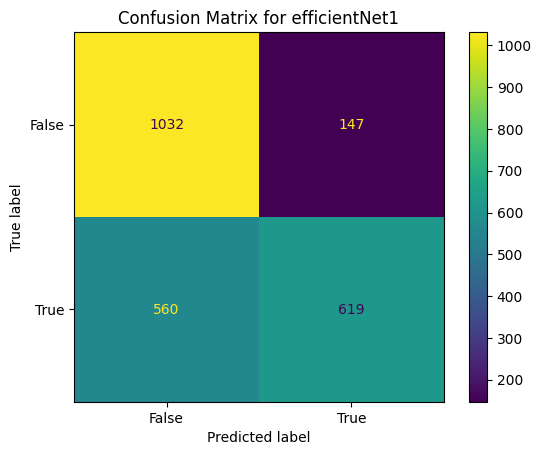

Epochs: 4
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.631647030711174
Batch 100, Training Acc : 69.25 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6310345180131294
Training Accuracy: 69.72010178117048
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


Val Avg Loss: 0.6220155165002152
Val Accuracy: 71.67090754877015 %
pAUC Score: 0.03854809437386568
Epochs: 5
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6257726854085922
Batch 100, Training Acc : 71.84375 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6286129721918622
Training Accuracy: 71.27862595419847
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Val Avg Loss: 0.6169713010659089
Val Accuracy: 74.21543681085666 %
pAUC Score: 0.04498905908096279
Epochs: 6
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.16it/s]

Batch 100,  Training Loss : 0.6265362185239792
Batch 100, Training Acc : 71.9375 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.6250257576639587
Training Accuracy: 72.11620016963528
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.6120495522344435
Val Accuracy: 74.25784563189143 %
pAUC Score: 0.04292585170340678

Classification Report For efficientNet1 :
               precision    recall  f1-score   support

           0       0.68      0.91      0.78      1179
           1       0.86      0.58      0.69      1179

    accuracy                           0.74      2358
   macro avg       0.77      0.74      0.74      2358
weighted avg       0.77      0.74      0.74      2358



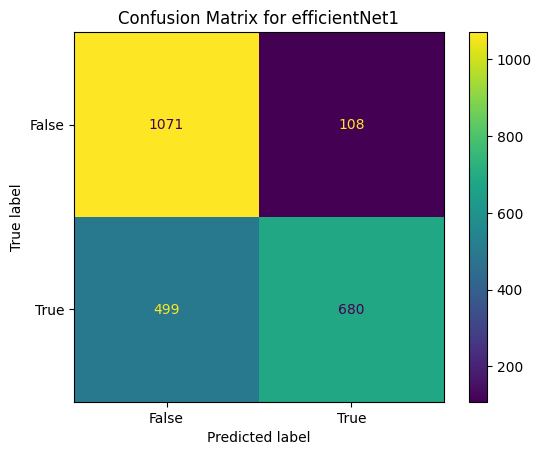

Epochs: 7
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.16it/s]

Batch 100,  Training Loss : 0.6201922684907913
Batch 100, Training Acc : 72.671875 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.620854480443774
Training Accuracy: 72.7735368956743
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Val Avg Loss: 0.6122134327888489
Val Accuracy: 74.21543681085666 %
pAUC Score: 0.0435463917525773
Epochs: 8
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6184984940290451
Batch 100, Training Acc : 72.609375 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.6185558168469248
Training Accuracy: 73.09160305343511
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Val Avg Loss: 0.614504920469748
Val Accuracy: 73.40966921119593 %
pAUC Score: 0.04106870229007633
Epochs: 9
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6190496212244034
Batch 100, Training Acc : 73.515625 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6181775105966104
Training Accuracy: 73.36726039016115
Validation:


100%|██████████| 37/37 [00:16<00:00,  2.27it/s]


Val Avg Loss: 0.607774513798791
Val Accuracy: 76.5479219677693 %
pAUC Score: 0.05210256410256408

Classification Report For efficientNet1 :
               precision    recall  f1-score   support

           0       0.72      0.86      0.79      1179
           1       0.83      0.67      0.74      1179

    accuracy                           0.77      2358
   macro avg       0.78      0.77      0.76      2358
weighted avg       0.78      0.77      0.76      2358



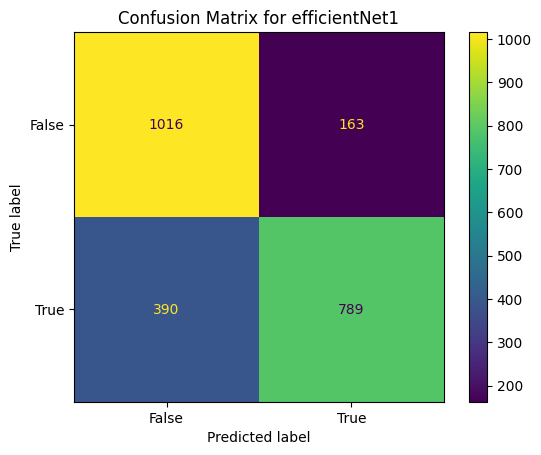

Epochs: 10
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.614081968665123
Batch 100, Training Acc : 74.4375 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6145326503225275
Training Accuracy: 74.58651399491094
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]


Val Avg Loss: 0.6076849280176936
Val Accuracy: 74.89397794741306 %
pAUC Score: 0.044612159329140436
Epochs: 11
Training:


 68%|██████▊   | 100/148 [01:29<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6139106845855713
Batch 100, Training Acc : 74.328125 %


100%|██████████| 148/148 [02:10<00:00,  1.13it/s]


Training Avg Loss: 0.6131057928542833
Training Accuracy: 74.55470737913485
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Val Avg Loss: 0.6141559191652246
Val Accuracy: 72.56149279050042 %
pAUC Score: 0.03889875666074599
Epochs: 12
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6101024866104126
Batch 100, Training Acc : 74.765625 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.611920910509857
Training Accuracy: 74.93638676844783
Validation:


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Val Avg Loss: 0.6063924464019569
Val Accuracy: 75.48770144189992 %
pAUC Score: 0.045738758029978566

Classification Report For efficientNet1 :
               precision    recall  f1-score   support

           0       0.70      0.91      0.79      1179
           1       0.87      0.60      0.71      1179

    accuracy                           0.75      2358
   macro avg       0.78      0.75      0.75      2358
weighted avg       0.78      0.75      0.75      2358



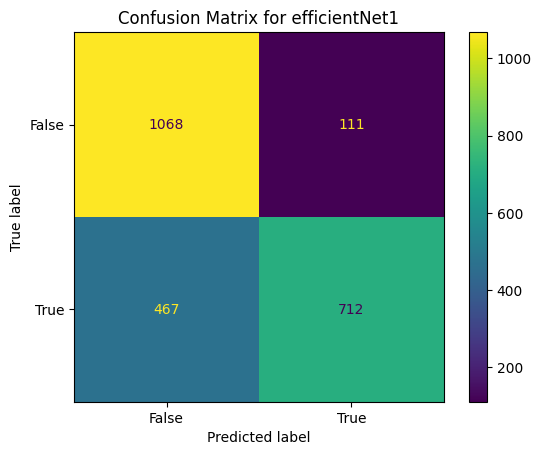

Epochs: 13
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6093767988681793
Batch 100, Training Acc : 75.59375 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.6102652730973991
Training Accuracy: 75.44529262086515
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.6027051742012436
Val Accuracy: 76.7175572519084 %
pAUC Score: 0.0489655172413793
Epochs: 14
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.604903769493103
Batch 100, Training Acc : 76.15625 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.6088411215994809
Training Accuracy: 75.6891433418151
Validation:


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Val Avg Loss: 0.6064564811216818
Val Accuracy: 75.8693808312129 %
pAUC Score: 0.047415730337078625
Epochs: 15
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6079994422197342
Batch 100, Training Acc : 75.0625 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6072305316055143
Training Accuracy: 75.57251908396947
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Val Avg Loss: 0.60632332595619
Val Accuracy: 75.14843087362172 %
pAUC Score: 0.043911290322580614

Classification Report For efficientNet1 :
               precision    recall  f1-score   support

           0       0.69      0.92      0.79      1179
           1       0.88      0.58      0.70      1179

    accuracy                           0.75      2358
   macro avg       0.79      0.75      0.74      2358
weighted avg       0.79      0.75      0.74      2358



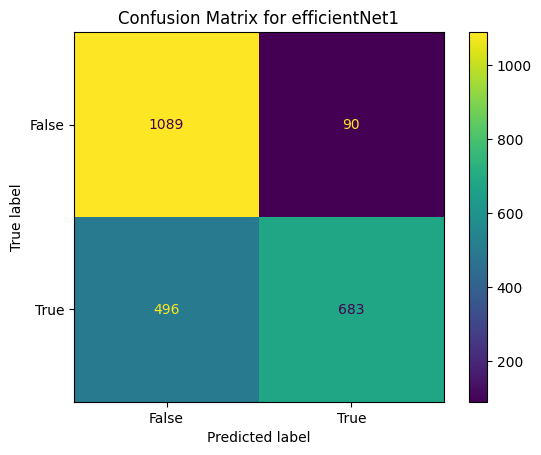

Epochs: 16
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.16it/s]

Batch 100,  Training Loss : 0.6113342636823654
Batch 100, Training Acc : 74.46875 %


100%|██████████| 148/148 [02:09<00:00,  1.14it/s]


Training Avg Loss: 0.61042404698359
Training Accuracy: 75.08481764206955
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


Val Avg Loss: 0.6006546374913808
Val Accuracy: 76.97201017811705 %
pAUC Score: 0.04904109589041092
Epochs: 17
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6080919581651688
Batch 100, Training Acc : 75.703125 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6062937745371381
Training Accuracy: 76.15564037319763
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Val Avg Loss: 0.6010661221839286
Val Accuracy: 77.18405428329092 %
pAUC Score: 0.05037914691943127
Epochs: 18
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6078067630529403
Batch 100, Training Acc : 76.296875 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6060961827233031
Training Accuracy: 76.5479219677693
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Val Avg Loss: 0.6033724594760586
Val Accuracy: 76.33587786259542 %
pAUC Score: 0.047723214285714285

Classification Report For efficientNet1 :
               precision    recall  f1-score   support

           0       0.70      0.91      0.79      1179
           1       0.87      0.62      0.72      1179

    accuracy                           0.76      2358
   macro avg       0.79      0.76      0.76      2358
weighted avg       0.79      0.76      0.76      2358



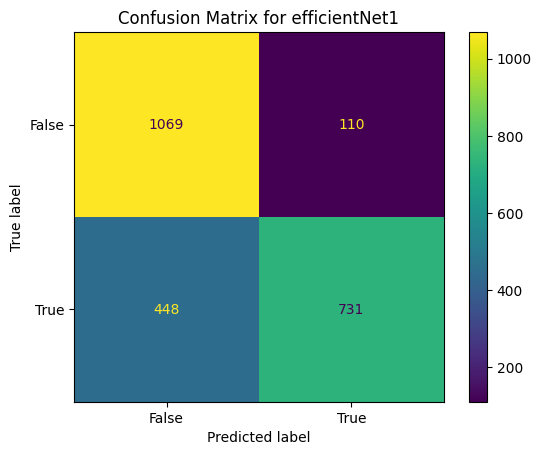

Epochs: 19
Training:


 68%|██████▊   | 100/148 [01:28<00:41,  1.15it/s]

Batch 100,  Training Loss : 0.6044793373346329
Batch 100, Training Acc : 76.671875 %


100%|██████████| 148/148 [02:10<00:00,  1.14it/s]


Training Avg Loss: 0.6048119176883955
Training Accuracy: 76.34648006785412
Validation:


100%|██████████| 37/37 [00:16<00:00,  2.30it/s]

Val Avg Loss: 0.5969324305250838
Val Accuracy: 77.77777777777777 %
pAUC Score: 0.049840546697038704
Early Stop!
CPU times: user 43min 26s, sys: 1min 8s, total: 44min 35s
Wall time: 46min 29s


In [ ]:
%%time
if CFG.USE_EFFECTNetv1:
    print("Start Training : efficientNet1")
    print(f"Number of GPU: {torch.cuda.device_count()}")
#     if torch.cuda.device_count() > 1:
#         efficientNet1 = nn.DataParallel(efficientNet1 , device_ids=[0, 1])  # Specify the GPU ids
    trainValLoop(efficientNet1, optimizer1, "efficientNet1", 200) #epochs=CFG.trainEpochs)
#     args = ("fp16", 42, 64)
#     notebook_launcher(trainValLoop(efficientNet1, optimizer1, "efficientNet1", 2) , args, num_processes=2)

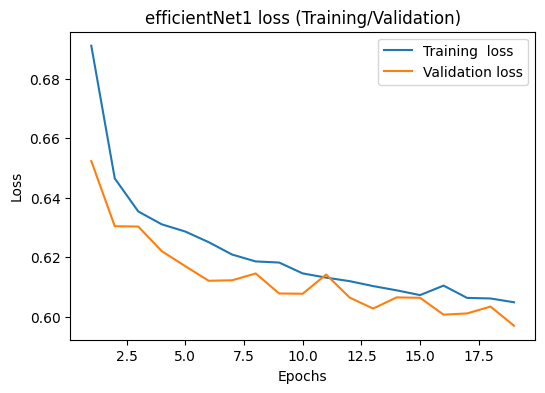

In [ ]:
if CFG.USE_EFFECTNetv1:
    plotLoss(epochList, trainLossHist, valLossHist, "efficientNet1")

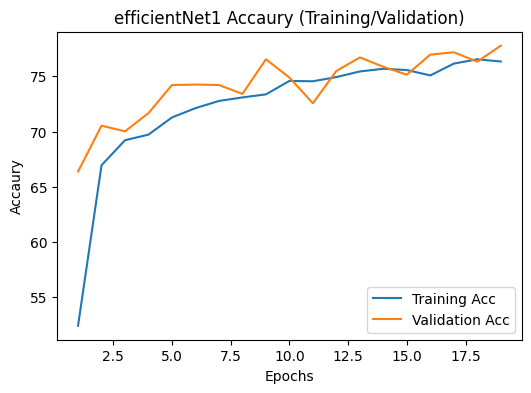

In [ ]:
if CFG.USE_EFFECTNetv1:
    plotAcc(epochList, trainAccHist, valAccHist, "efficientNet1")

In [ ]:
# valAccHist

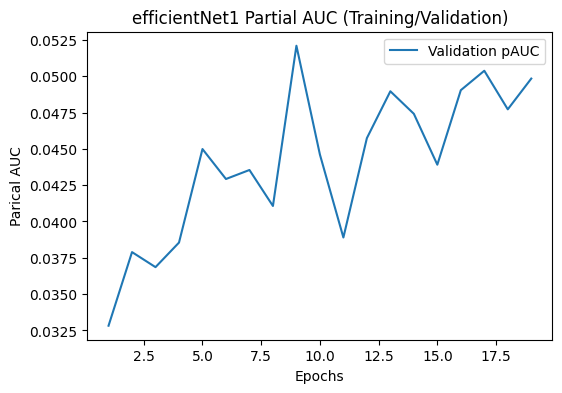

In [ ]:
if CFG.USE_EFFECTNetv1:
    plotpauc(epochList, paucHist, "efficientNet1")

In [ ]:
# len(val.target.values)

In [ ]:
clearTrainHist()
clearMemory()

Start Training : efficientNet2
Number of GPU: 2
Epochs: 1
Training:


 68%|██████▊   | 100/148 [01:17<00:31,  1.54it/s]

Batch 100,  Training Loss : 0.690286962389946
Batch 100, Training Acc : 52.15625 %


100%|██████████| 148/148 [01:51<00:00,  1.32it/s]


Training Avg Loss: 0.6729048857012311
Training Accuracy: 57.7078032230704
Validation:


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Val Avg Loss: 0.6234074508821642
Val Accuracy: 71.28922815945717 %
pAUC Score: 0.038221415607985476
Epochs: 2
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6275941109657288
Batch 100, Training Acc : 71.171875 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6270045762931978
Training Accuracy: 71.00296861747243
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.48it/s]


Val Avg Loss: 0.6143971439954397
Val Accuracy: 73.87616624257845 %
pAUC Score: 0.0427016129032258
Epochs: 3
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6268881344795227
Batch 100, Training Acc : 71.859375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6231980617787387
Training Accuracy: 72.48727735368956
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.52it/s]


Val Avg Loss: 0.6107961309922708
Val Accuracy: 75.57251908396947 %
pAUC Score: 0.047788018433179716

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.70      0.88      0.78      1179
           1       0.84      0.63      0.72      1179

    accuracy                           0.76      2358
   macro avg       0.77      0.76      0.75      2358
weighted avg       0.77      0.76      0.75      2358



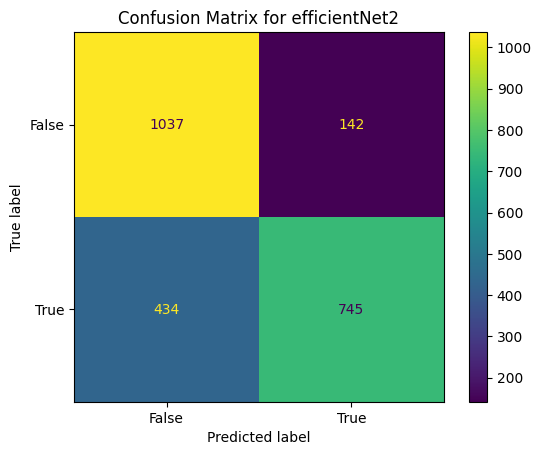

Epochs: 4
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.54it/s]

Batch 100,  Training Loss : 0.6182894706726074
Batch 100, Training Acc : 73.328125 %


100%|██████████| 148/148 [01:38<00:00,  1.50it/s]


Training Avg Loss: 0.6200364103188386
Training Accuracy: 73.13401187446989
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Val Avg Loss: 0.6221467659280107
Val Accuracy: 72.64631043256998 %
pAUC Score: 0.042111801242236
Epochs: 5
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6242637020349503
Batch 100, Training Acc : 72.59375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6209628086637806
Training Accuracy: 72.86895674300254
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.52it/s]


Val Avg Loss: 0.6072180255039318
Val Accuracy: 76.59033078880407 %
pAUC Score: 0.05119402985074626
Epochs: 6
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6165021765232086
Batch 100, Training Acc : 74.4375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6140272681777542
Training Accuracy: 75.22264631043257
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.5998387562262045
Val Accuracy: 78.7531806615776 %
pAUC Score: 0.058742857142857124

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.75      0.87      0.80      1179
           1       0.85      0.70      0.77      1179

    accuracy                           0.79      2358
   macro avg       0.80      0.79      0.79      2358
weighted avg       0.80      0.79      0.79      2358



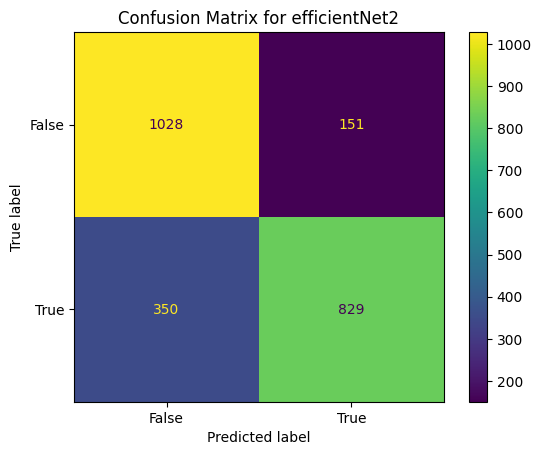

Epochs: 7
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.613341692686081
Batch 100, Training Acc : 75.671875 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6130197990585018
Training Accuracy: 75.25445292620866
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Val Avg Loss: 0.6071682717349078
Val Accuracy: 76.5479219677693 %
pAUC Score: 0.05137844611528818
Epochs: 8
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6071538388729095
Batch 100, Training Acc : 76.0 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6090783968165114
Training Accuracy: 76.09202714164546
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Val Avg Loss: 0.6039315220471975
Val Accuracy: 78.0746395250212 %
pAUC Score: 0.059171597633136064
Epochs: 9
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6077431327104569
Batch 100, Training Acc : 76.671875 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6101868756719537
Training Accuracy: 75.72094995759117
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Val Avg Loss: 0.6022238715274914
Val Accuracy: 76.50551314673451 %
pAUC Score: 0.04741228070175435

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.70      0.92      0.80      1179
           1       0.88      0.61      0.72      1179

    accuracy                           0.77      2358
   macro avg       0.79      0.77      0.76      2358
weighted avg       0.79      0.77      0.76      2358



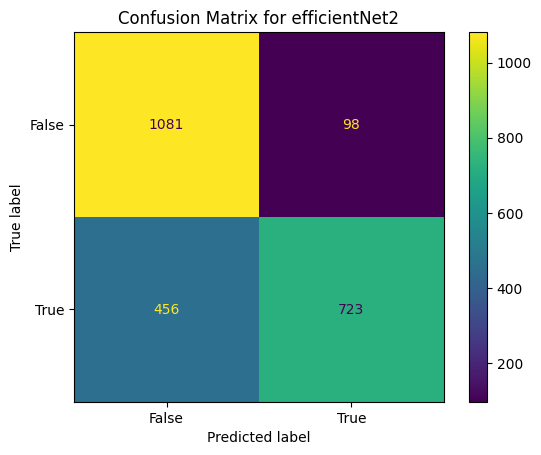

Epochs: 10
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6102610373497009
Batch 100, Training Acc : 75.21875 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6102221986731967
Training Accuracy: 75.87998303647159
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Val Avg Loss: 0.604523391337008
Val Accuracy: 78.83799830364715 %
pAUC Score: 0.06689655172413791
Epochs: 11
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6054172694683075
Batch 100, Training Acc : 76.90625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6071419373557374
Training Accuracy: 76.63273960983885
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Val Avg Loss: 0.6040679554681521
Val Accuracy: 75.82697201017811 %
pAUC Score: 0.04548117154811712
Epochs: 12
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6028245854377746
Batch 100, Training Acc : 77.203125 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6034681672180021
Training Accuracy: 77.15224766751484
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Val Avg Loss: 0.5991937872525808
Val Accuracy: 78.45631891433418 %
pAUC Score: 0.05769662921348313

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.74      0.87      0.80      1179
           1       0.84      0.70      0.76      1179

    accuracy                           0.78      2358
   macro avg       0.79      0.78      0.78      2358
weighted avg       0.79      0.78      0.78      2358



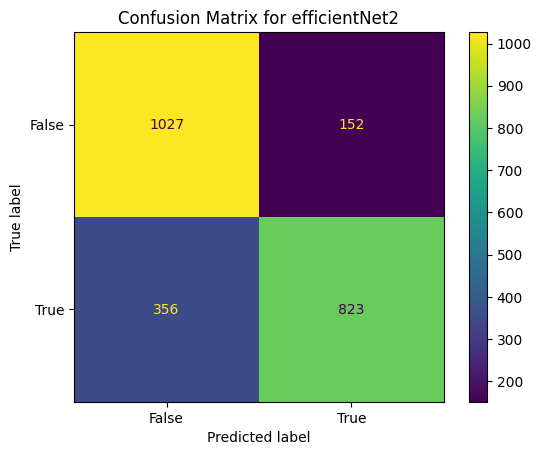

Epochs: 13
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6036918693780899
Batch 100, Training Acc : 77.390625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6042033574871115
Training Accuracy: 77.31128074639525
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Val Avg Loss: 0.6020847703959491
Val Accuracy: 78.79558948261239 %
pAUC Score: 0.06311111111111106
Epochs: 14
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6093372297286987
Batch 100, Training Acc : 76.4375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6057115910021035
Training Accuracy: 76.98261238337574
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


Val Avg Loss: 0.5965652723570127
Val Accuracy: 78.62595419847328 %
pAUC Score: 0.056784741144414154
Epochs: 15
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6030724525451661
Batch 100, Training Acc : 77.84375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6039114594459534
Training Accuracy: 77.44910941475827
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


Val Avg Loss: 0.5909425068545986
Val Accuracy: 80.02544529262086 %
pAUC Score: 0.06068965517241376

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      1179
           1       0.87      0.70      0.78      1179

    accuracy                           0.80      2358
   macro avg       0.81      0.80      0.80      2358
weighted avg       0.81      0.80      0.80      2358



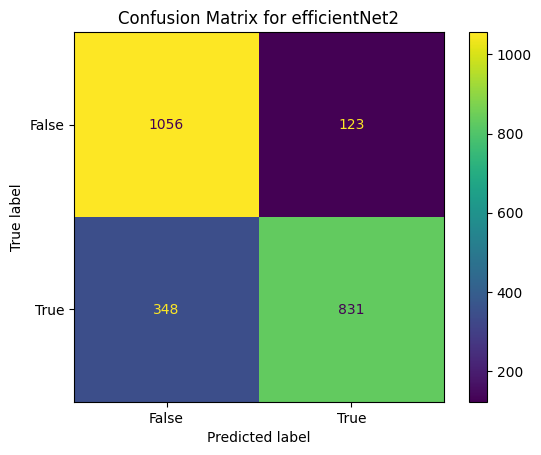

Epochs: 16
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5994690972566604
Batch 100, Training Acc : 78.65625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6019982135779148
Training Accuracy: 77.735368956743
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


Val Avg Loss: 0.5929927036568925
Val Accuracy: 79.55894826123834 %
pAUC Score: 0.05971509971509967
Epochs: 17
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5986846482753754
Batch 100, Training Acc : 78.953125 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5994640181998949
Training Accuracy: 78.84860050890585
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.51it/s]


Val Avg Loss: 0.5919634587055927
Val Accuracy: 81.08566581849024 %
pAUC Score: 0.07090277777777773
Epochs: 18
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.6021847891807556
Batch 100, Training Acc : 77.609375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.6016210567306828
Training Accuracy: 77.78837998303648
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


Val Avg Loss: 0.5904469038989093
Val Accuracy: 79.98303647158609 %
pAUC Score: 0.06005665722379603

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      1179
           1       0.87      0.70      0.78      1179

    accuracy                           0.80      2358
   macro avg       0.81      0.80      0.80      2358
weighted avg       0.81      0.80      0.80      2358



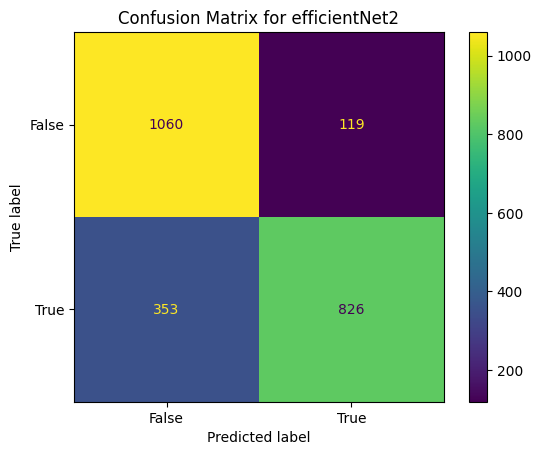

Epochs: 19
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5983570545911789
Batch 100, Training Acc : 77.9375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5988467045732446
Training Accuracy: 78.50932994062765
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]


Val Avg Loss: 0.5910917633288616
Val Accuracy: 79.94062765055132 %
pAUC Score: 0.05889807162534435
Epochs: 20
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5993817210197449
Batch 100, Training Acc : 78.0 %


100%|██████████| 148/148 [01:38<00:00,  1.49it/s]


Training Avg Loss: 0.6002377356226379
Training Accuracy: 77.63994910941476
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.5984231314143619
Val Accuracy: 77.35368956743002 %
pAUC Score: 0.04999999999999996
Epochs: 21
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.596565129160881
Batch 100, Training Acc : 78.5625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5971629003415236
Training Accuracy: 78.48812553011027
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.5948718415724265
Val Accuracy: 79.21967769296013 %
pAUC Score: 0.059036827195467406

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.75      0.88      0.81      1179
           1       0.86      0.70      0.77      1179

    accuracy                           0.79      2358
   macro avg       0.80      0.79      0.79      2358
weighted avg       0.80      0.79      0.79      2358



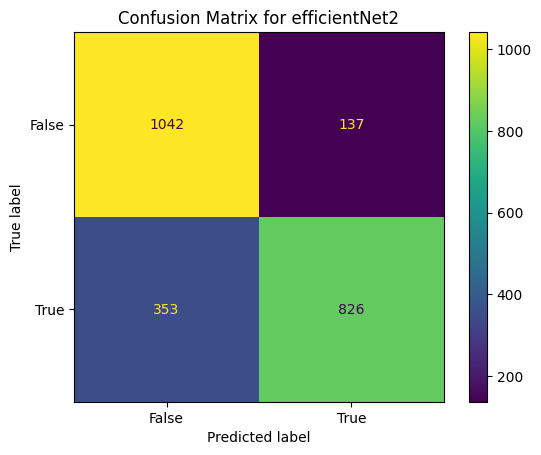

Epochs: 22
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5957172924280166
Batch 100, Training Acc : 79.484375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5972403243586824
Training Accuracy: 79.13486005089058
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Val Avg Loss: 0.5943574905395508
Val Accuracy: 79.17726887192536 %
pAUC Score: 0.05759562841530051
Epochs: 23
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5991965228319168
Batch 100, Training Acc : 78.84375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5964610604821025
Training Accuracy: 78.9334181509754
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.6005997770541424
Val Accuracy: 77.43850720949958 %
pAUC Score: 0.05140776699029122
Epochs: 24
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5971738791465759
Batch 100, Training Acc : 78.90625 %


100%|██████████| 148/148 [01:38<00:00,  1.50it/s]


Training Avg Loss: 0.5976827450700708
Training Accuracy: 78.76378286683631
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.42it/s]


Val Avg Loss: 0.5936061917124568
Val Accuracy: 79.6437659033079 %
pAUC Score: 0.06017241379310343

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.75      0.89      0.81      1179
           1       0.86      0.70      0.78      1179

    accuracy                           0.80      2358
   macro avg       0.81      0.80      0.79      2358
weighted avg       0.81      0.80      0.79      2358



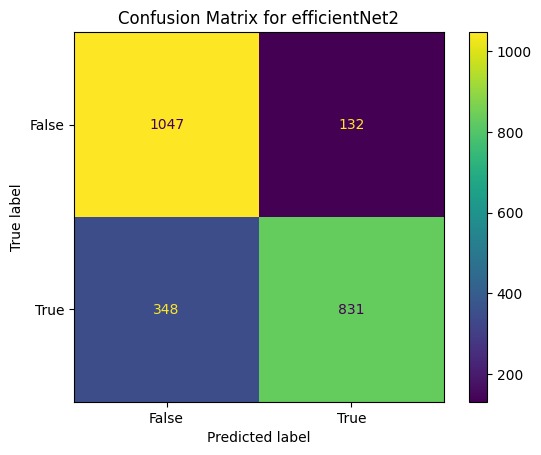

Epochs: 25
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5955937159061432
Batch 100, Training Acc : 79.15625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5956409480926153
Training Accuracy: 79.19847328244275
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


Val Avg Loss: 0.5879641513566713
Val Accuracy: 81.8490245971162 %
pAUC Score: 0.07799227799227795
Epochs: 26
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5933899015188218
Batch 100, Training Acc : 79.390625 %


100%|██████████| 148/148 [01:38<00:00,  1.50it/s]


Training Avg Loss: 0.5953986540034011
Training Accuracy: 79.36810856658185
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Val Avg Loss: 0.5913425023491318
Val Accuracy: 78.79558948261239 %
pAUC Score: 0.05272289156626506
Epochs: 27
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5899566954374313
Batch 100, Training Acc : 79.84375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5921889797255799
Training Accuracy: 80.25869380831213
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


Val Avg Loss: 0.5912664661536345
Val Accuracy: 81.00084817642069 %
pAUC Score: 0.07202846975088964

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1179
           1       0.84      0.76      0.80      1179

    accuracy                           0.81      2358
   macro avg       0.81      0.81      0.81      2358
weighted avg       0.81      0.81      0.81      2358



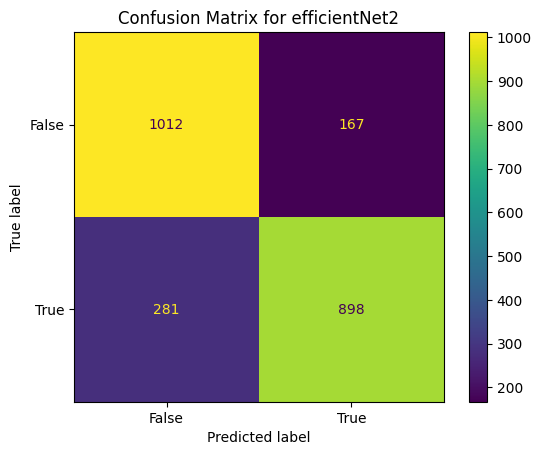

Epochs: 28
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5923695570230484
Batch 100, Training Acc : 79.34375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5943404621369129
Training Accuracy: 79.54834605597965
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Val Avg Loss: 0.5874430521114452
Val Accuracy: 81.55216284987277 %
pAUC Score: 0.07221052631578945
Epochs: 29
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5901543521881103
Batch 100, Training Acc : 80.640625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5916804542412629
Training Accuracy: 80.08905852417303
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.51it/s]


Val Avg Loss: 0.588093498268643
Val Accuracy: 80.36471586089907 %
pAUC Score: 0.0593406593406593
Epochs: 30
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.59414071559906
Batch 100, Training Acc : 79.28125 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5951466785894858
Training Accuracy: 79.14546225614927
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Val Avg Loss: 0.5882876354294855
Val Accuracy: 80.95843935538592 %
pAUC Score: 0.06620253164556959

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.77      0.89      0.82      1179
           1       0.87      0.73      0.79      1179

    accuracy                           0.81      2358
   macro avg       0.82      0.81      0.81      2358
weighted avg       0.82      0.81      0.81      2358



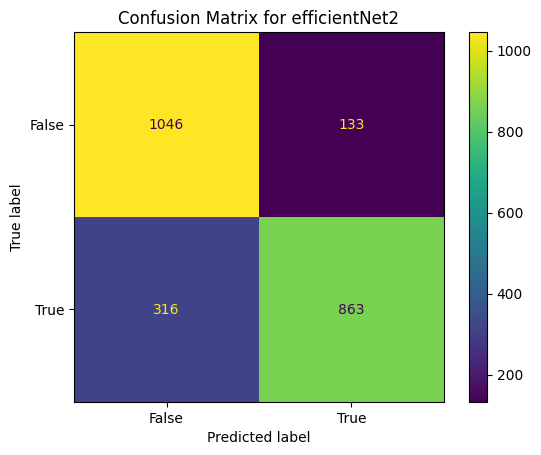

Epochs: 31
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.54it/s]

Batch 100,  Training Loss : 0.593929300904274
Batch 100, Training Acc : 80.515625 %


100%|██████████| 148/148 [01:38<00:00,  1.50it/s]


Training Avg Loss: 0.5913443513013221
Training Accuracy: 80.58736217133163
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Val Avg Loss: 0.5835703192530451
Val Accuracy: 81.97625106022052 %
pAUC Score: 0.07026666666666662
Epochs: 32
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5874534243345261
Batch 100, Training Acc : 81.484375 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5905651039368397
Training Accuracy: 80.990245971162
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Val Avg Loss: 0.5855719785432558
Val Accuracy: 81.25530110262935 %
pAUC Score: 0.06649842271293374
Epochs: 33
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5902041977643967
Batch 100, Training Acc : 80.578125 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5896647608763462
Training Accuracy: 80.72519083969466
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Val Avg Loss: 0.5757998614697843
Val Accuracy: 83.16369804919424 %
pAUC Score: 0.07374570446735393

Classification Report For efficientNet2 :
               precision    recall  f1-score   support

           0       0.79      0.91      0.84      1179
           1       0.89      0.75      0.82      1179

    accuracy                           0.83      2358
   macro avg       0.84      0.83      0.83      2358
weighted avg       0.84      0.83      0.83      2358



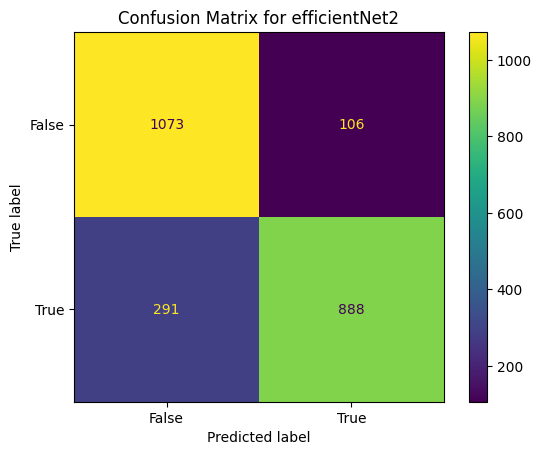

Epochs: 34
Training:


 68%|██████▊   | 100/148 [01:08<00:31,  1.51it/s]

Batch 100,  Training Loss : 0.5861344283819199
Batch 100, Training Acc : 80.515625 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5894372157148413
Training Accuracy: 80.67217981340119
Validation:


100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


Val Avg Loss: 0.5868826460193943
Val Accuracy: 81.6793893129771 %
pAUC Score: 0.07354838709677414
Epochs: 35
Training:


 68%|██████▊   | 100/148 [01:07<00:31,  1.53it/s]

Batch 100,  Training Loss : 0.5853550601005554
Batch 100, Training Acc : 81.28125 %


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


Training Avg Loss: 0.5887367483731862
Training Accuracy: 81.23409669211196
Validation:


100%|██████████| 37/37 [00:15<00:00,  2.35it/s]

Val Avg Loss: 0.5843367496052304
Val Accuracy: 81.6793893129771 %
pAUC Score: 0.06788461538461535
Early Stop!
CPU times: user 1h 35s, sys: 2min 17s, total: 1h 2min 52s
Wall time: 1h 7min 7s


In [ ]:
%%time
if CFG.USE_EFFECTNetv2:
    print("Start Training : efficientNet2")
    print(f"Number of GPU: {torch.cuda.device_count()}")
    trainValLoop(efficientNetV2, optimizer2, "efficientNet2", 200) #epochs=CFG.trainEpochs)

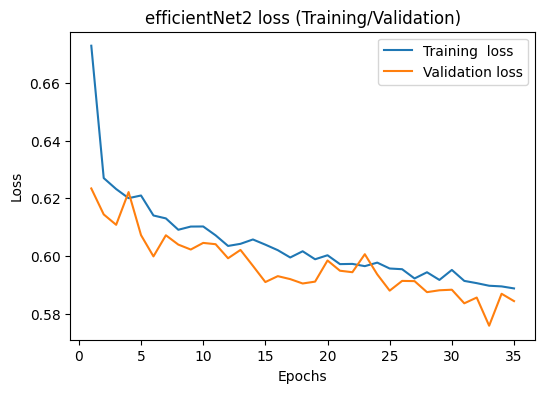

In [ ]:
if CFG.USE_EFFECTNetv2:
    plotLoss(epochList, trainLossHist, valLossHist, "efficientNet2")

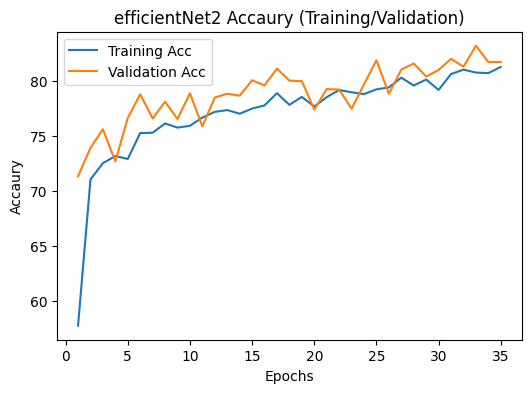

In [ ]:
if CFG.USE_EFFECTNetv2:
    plotAcc(epochList, trainAccHist, valAccHist, "efficientNet2")

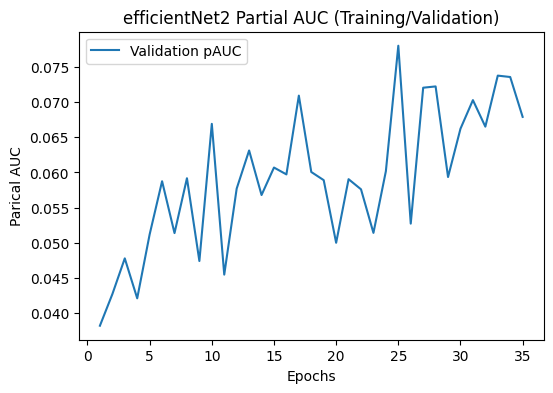

In [ ]:
if CFG.USE_EFFECTNetv2:
    plotpauc(epochList, paucHist, "efficientNet2")

In [ ]:
clearTrainHist()
clearMemory()

In [ ]:
%%time
if CFG.USE_SWINTransV1:
    print("Start Training : SWIN TransV1")
    print(f"Number of GPU: {torch.cuda.device_count()}")
    trainValLoop(swinTranV1, optimizer3, "swinTransV1", 200) #epochs=CFG.trainEpochs)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 8.82 µs


In [ ]:
if CFG.USE_SWINTransV1:
    plotLoss(epochList, trainLossHist, valLossHist, "swinTransV1")

In [ ]:
if CFG.USE_SWINTransV1:
    plotAcc(epochList, trainAccHist, valAccHist, "swinTransV1")

In [ ]:
if CFG.USE_SWINTransV1:
    plotpauc(epochList, paucHist, "swinTransV1")

In [ ]:
clearTrainHist()
clearMemory()

In [ ]:
%%time
if CFG.USE_SWINTransV2:
    print("Start Training : SWIN TransV2")
    print(f"Number of GPU: {torch.cuda.device_count()}")
    trainValLoop(swinTranV2, optimizer4, "swinTransV2", 200) #epochs=CFG.trainEpochs)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [ ]:
if CFG.USE_SWINTransV2:
    plotLoss(epochList, trainLossHist, valLossHist, "swinTransV2")

In [ ]:
if CFG.USE_SWINTransV2:
    plotAcc(epochList, trainAccHist, valAccHist, "swinTransV2")

In [ ]:
if CFG.USE_SWINTransV2:
    plotpauc(epochList, paucHist, "swinTransV2")

In [ ]:
clearTrainHist()
clearMemory()

In [ ]:
if CFG.USE_VITrans:
    print("Start Training : vitTrainV1")
    print(f"Number of GPU: {torch.cuda.device_count()}")
    trainValLoop(vitTrain1, optimizer5, "vitTrainV1", 200) #epochs=CFG.trainEpochs)

In [ ]:
if CFG.USE_VITrans:
    plotLoss(epochList, trainLossHist, valLossHist, "vitTrainV1")

In [ ]:
if CFG.USE_VITrans:
    plotAcc(epochList, trainAccHist, valAccHist, "vitTrainV1")

In [ ]:
if CFG.USE_VITrans:
    plotpauc(epochList, paucHist, "vitTrainV1")

In [ ]:
clearTrainHist()
clearMemory()

In [ ]:
if CFG.USE_VITrans3:
    print("Start Training : vitTrainV3")
    print(f"Number of GPU: {torch.cuda.device_count()}")
    trainValLoop(vitTrain3, optimizer6, "vitTrainV3", 200) #epochs=CFG.trainEpochs)

In [ ]:
if CFG.USE_VITrans3:
    plotLoss(epochList, trainLossHist, valLossHist, "vitTrainV3")

In [ ]:
if CFG.USE_VITrans3:
    plotAcc(epochList, trainAccHist, valAccHist, "vitTrainV3")

In [ ]:
if CFG.USE_VITrans3:
    plotpauc(epochList, paucHist, "vitTrainV3")

In [ ]:
clearTrainHist()
clearMemory()

In [ ]:
def findBestModel():
    bestModel= ""
    bestAcc =0
    bestScore = 0
    bestLoss = np.inf   # init to infinity
    for k, v in modelHistory.items():
        modelAcc = v["best_acc"]
        modelLoss = v["best_loss"]
        modelScore = v["best_score"]
        print("Model: ", k)
        print("Model Best Acc: ", modelAcc)
        print("Model Best Loss: ", modelLoss)
        print("Mobel Best Score: ", modelScore)
        if bestScore < modelScore:
             # update best model
                bestModel = k
                bestAcc = modelAcc
                bestLoss = modelLoss
                bestScore = modelScore
                print("beatModel: ", bestModel )
#         if bestLoss > modelLoss:
#             if bestAcc <  modelAcc:
#                 # update best model
#                 bestModel = k
#                 bestAcc = modelAcc
#                 bestLoss = modelLoss

#             print("beatModel: ", bestModel )

    if bestModel == "efficientNet1":
        print("Final Model: efficientNet1")
        return efficientNet1
    elif bestModel == "efficientNet2":
        print("Final Model: efficientNet2")
        return efficientNetV2
    elif bestModel == "swinTransV1":
        print("Final Model: swinTransV1")
        return swinTranV1
    elif bestModel == "swinTransV2":
        print("Final Model: swinTransV2")
        return swinTranV2
    elif bestModel == "vitTrainV1":
        print("Final Model: vitTrainV1")
        return vitTrain1
    elif bestModel == "vitTrainV3":
        print("Final Model: vitTrainV3")
        return vitTrain3
    else:
        return None






In [ ]:
finalModel =  findBestModel()

Model:  efficientNet1
Model Best Acc:  77.77777777777777
Model Best Loss:  0.5969324305250838
Mobel Best Score:  0.05210256410256408
beatModel:  efficientNet1
Model:  efficientNet2
Model Best Acc:  83.16369804919424
Model Best Loss:  0.5757998614697843
Mobel Best Score:  0.07799227799227795
beatModel:  efficientNet2
Final Model: efficientNet2


# Prepare Submit

In [ ]:
submitPred = inferFunc(finalModel, testDataLoader)
submitPred

array([[0.5001849 ],
       [0.5       ],
       [0.50000215]], dtype=float32)

In [ ]:
submission

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [ ]:
submission["target"]=submitPred

In [ ]:
submission

,isic_id,target
0,ISIC_0015657,0.500185
1,ISIC_0015729,0.500000
2,ISIC_0015740,0.500002


In [ ]:
submission.to_csv('submission.csv', index=False)